<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
</center>

# [Projet machine learning](Projet-ML)

## Objectifs : 
<span style="color:  rgb(139, 0, 0)">**Notre projet consiste à analyser et faire des prédictions sur un jeu de données qui fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures de la condition physique des membres d’une salle de sport. Il y a deux objectifs principales pour ce projet :  Le premier objectif est de faire une analyse exploratoire des données pour bien cerner nos données. Dans un second temps, on effectuera deux modélisations avec la prédiction de calories brulées et du niveau d'expérience.**</span>

## Table des matières
1. [Analyse explorative des données (langage R)](#analyse-données)
   - Description général (natures des variables, encodages ...)
   - Analyse descriptive unidimensionnelle et bidimensionnelle
   - ACP des différentes variables
2. [Modélisation (langage R et python)](#modélisation)
   - Prédiction des calories brulées (régression)
   - Prédiction du niveau d'expérience (classification)
# 1. Analyse explorative des donées (langage R)
Cette partie se fera uniquement en R, l'analyse est dans l'autre notebook.

# 2. Modélisation (langage python)

# 2.1 Prédiction des calories brulées (régression)

## 2.1.1 Ajustement des données 

Avant tout, on va importer nos données et appliquer les modifications faites durant la première partie explorative en R en python. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

data=pd.read_csv("gym_members_exercise_tracking.csv",sep=",",header=0)
data.head()
data.dtypes
#On doit vérifier si les types sont bon, par exemple on va interpréter Experience_Level et Workout_Frequency comme des variables qualitatives avec des modalités. 

Age                                int64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                            int64
Avg_BPM                            int64
Resting_BPM                        int64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Type                      object
Fat_Percentage                   float64
Water_Intake (liters)            float64
Workout_Frequency (days/week)      int64
Experience_Level                   int64
BMI                              float64
dtype: object

On va transformer nos données qualitatives en catégories pour pouvoir les transformées en données numériques exploitables grâce à la fonction *get_dummies* de *panda* . 

In [ ]:
#Transformation de nos données au bon format voulu
data["Gender"]=pd.Categorical(data["Gender"],ordered=False)
data["Workout_Type"]=pd.Categorical(data["Workout_Type"],ordered=False)
data["Workout_Frequency (days/week)"]=pd.Categorical(data["Workout_Frequency (days/week)"],ordered=False)
data["Experience_Level"]=pd.Categorical(data["Experience_Level"],ordered=False)
data.dtypes

Age                                 int64
Gender                           category
Weight (kg)                       float64
Height (m)                        float64
Max_BPM                             int64
Avg_BPM                             int64
Resting_BPM                         int64
Session_Duration (hours)          float64
Calories_Burned                   float64
Workout_Type                     category
Fat_Percentage                    float64
Water_Intake (liters)             float64
Workout_Frequency (days/week)    category
Experience_Level                 category
BMI                               float64
dtype: object

In [ ]:
data.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,49.840000


On va maintenant récupérer les variables explicatives en transformant les données de manière a pouvoir les utiliser en régression et classification. 

In [ ]:
#Variables explicatives
################Variables qualitatives
dataDum=pd.get_dummies(data[["Gender","Workout_Type","Workout_Frequency (days/week)","Experience_Level"]]) 
# pour transformer des variables qualitatives en variables indicatrices, 
# chaque valeur unique de la variable qualitative devient une colonne distincte dans le DataFrame résultant

################Variables quantitatives
dataQuant=data[["Age","Weight (kg)","Height (m)","Max_BPM","Avg_BPM","Resting_BPM","Session_Duration (hours)","Fat_Percentage","Water_Intake (liters)","BMI"]] 

# Concaténation des variables explicatives
dfC=pd.concat([dataDum,dataQuant],axis=1)
dfC.head()
#print(type(dfC))
dfC.dtypes

Gender_Female                         bool
Gender_Male                           bool
Workout_Type_Cardio                   bool
Workout_Type_HIIT                     bool
Workout_Type_Strength                 bool
Workout_Type_Yoga                     bool
Workout_Frequency (days/week)_2       bool
Workout_Frequency (days/week)_3       bool
Workout_Frequency (days/week)_4       bool
Workout_Frequency (days/week)_5       bool
Experience_Level_1                    bool
Experience_Level_2                    bool
Experience_Level_3                    bool
Age                                  int64
Weight (kg)                        float64
Height (m)                         float64
Max_BPM                              int64
Avg_BPM                              int64
Resting_BPM                          int64
Session_Duration (hours)           float64
Fat_Percentage                     float64
Water_Intake (liters)              float64
BMI                                float64
dtype: obje

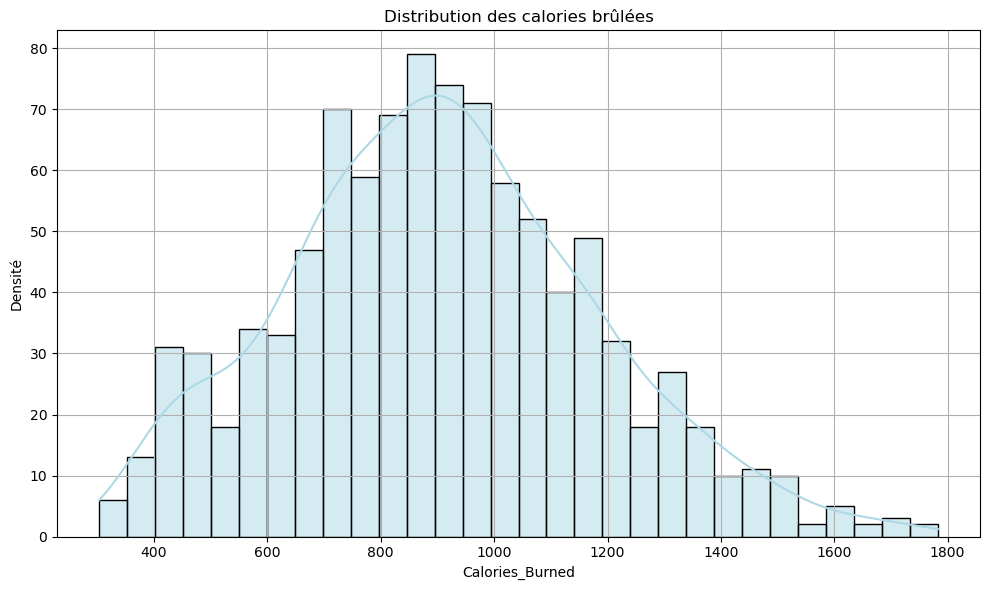

In [ ]:
import seaborn as sns
#Variables à prédire/expliquer 
YC=data["Calories_Burned"]
#print(type(YC))
# Paramètres personnalisables
bw = 50  # Largeur des bins (modifiable)
title = "Distribution des calories brûlées"

# Tracé
plt.figure(figsize=(10, 6))
sns.histplot(YC, kde=True, binwidth=bw, color="lightblue", edgecolor="black")
plt.title(title)
plt.xlabel("Calories_Burned")
plt.ylabel("Densité")
plt.grid(True)
plt.tight_layout()
plt.show()

On va tracer des histogrammes de nos variables continues pour appliquées des transformations si besoin. 

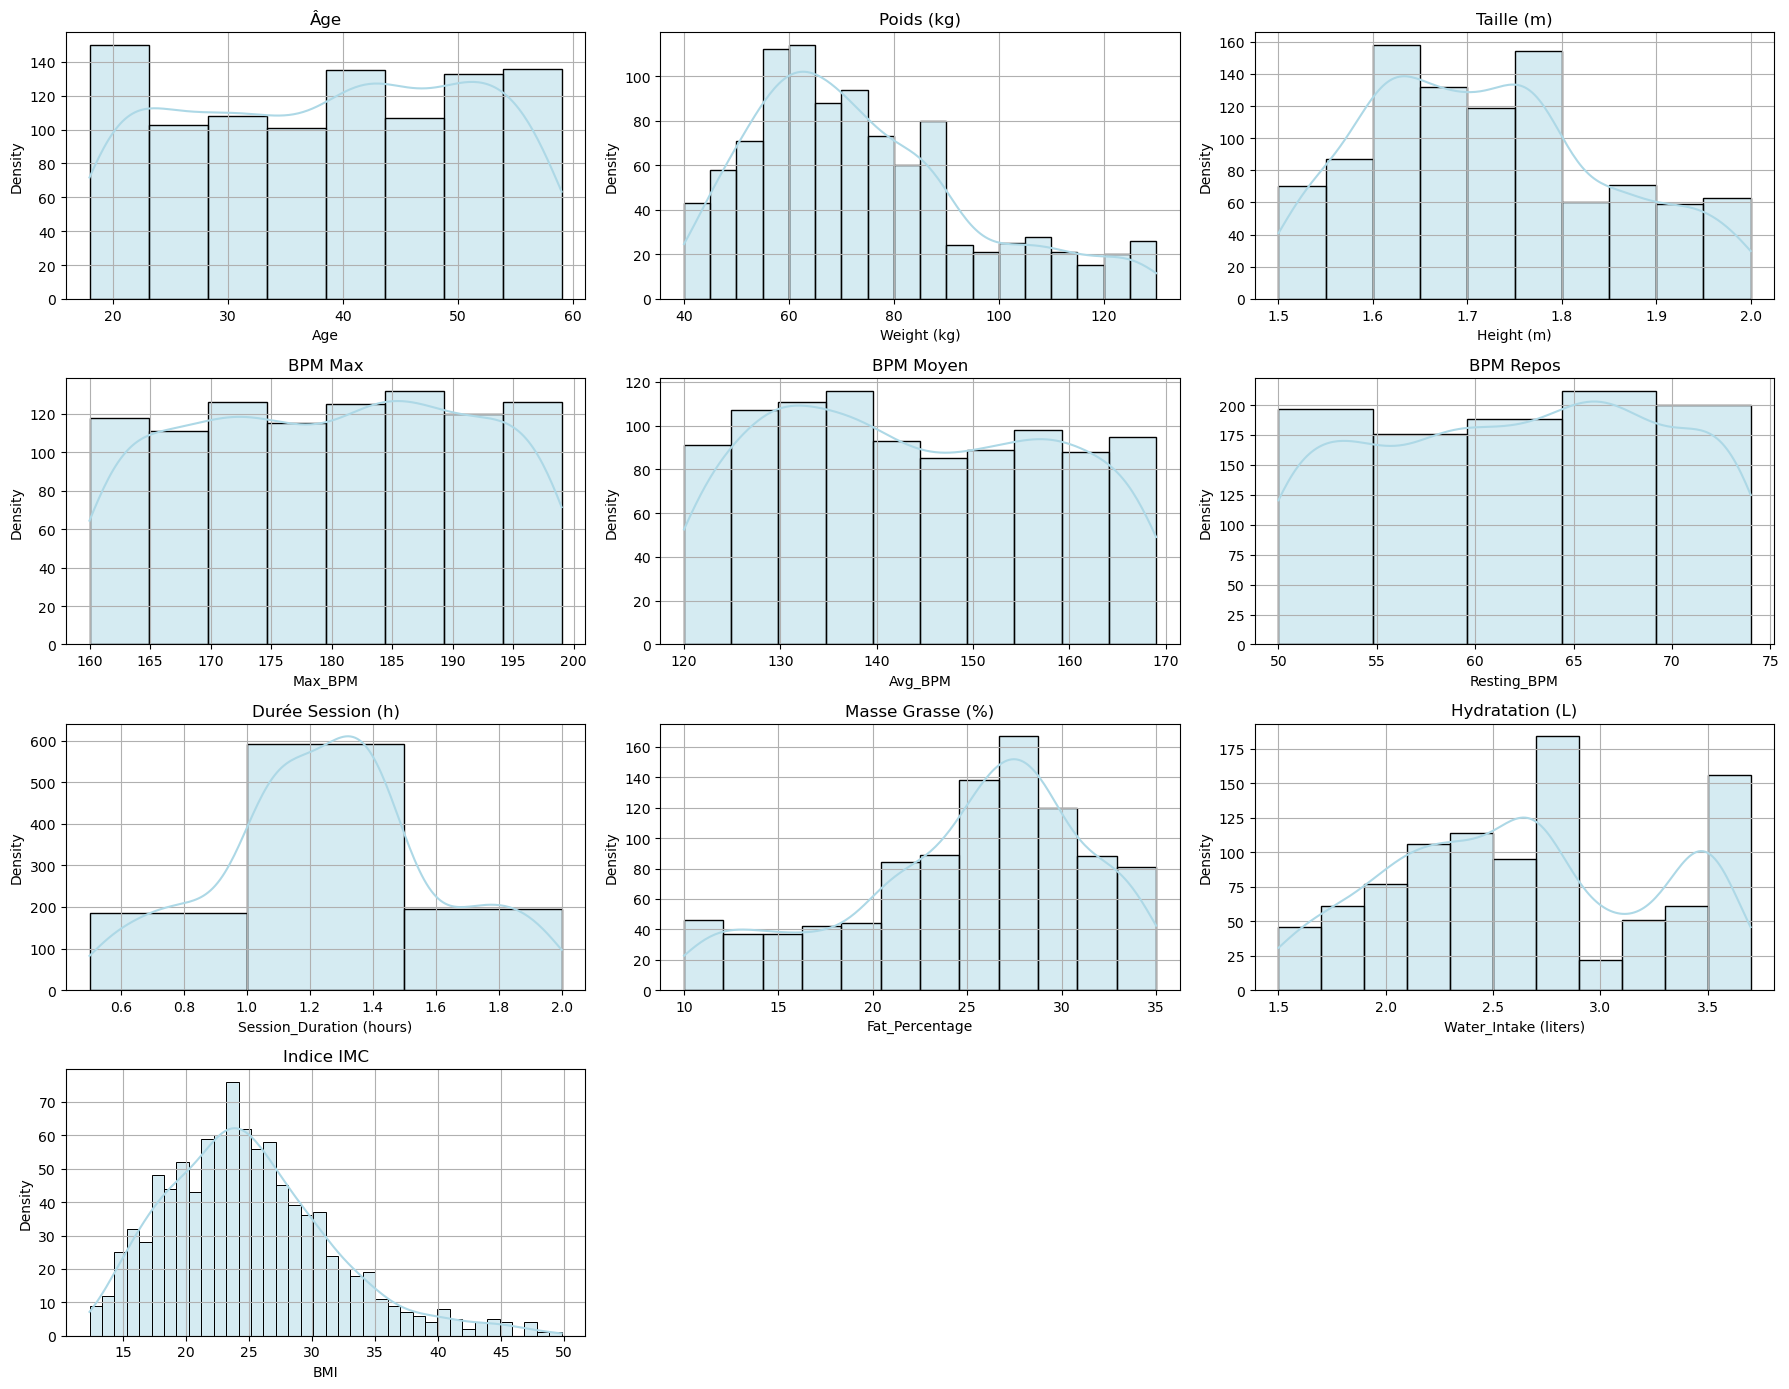

In [ ]:

# on trace les histogrammes des variables continues non transformées
# pour détecter les asymétries, valeurs extrêmes etc

plots = [
    ('Age', "Âge", 5),
    ('Weight (kg)', "Poids (kg)", 5),
    ('Height (m)', "Taille (m)", 0.05),
    ('Max_BPM', "BPM Max", 5),
    ('Avg_BPM', "BPM Moyen", 5),
    ('Resting_BPM', "BPM Repos", 5),
    ('Session_Duration (hours)', "Durée Session (h)", 0.5),
    ('Fat_Percentage', "Masse Grasse (%)", 2),
    ('Water_Intake (liters)', "Hydratation (L)", 0.2),
    ('BMI', "Indice IMC", 1),
]
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 14))
axs = axs.flatten()

for ax, (col, title, bw) in zip(axs, plots):
    sns.histplot(dfC[col], kde=True, binwidth=bw, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

for ax in axs[len(plots):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


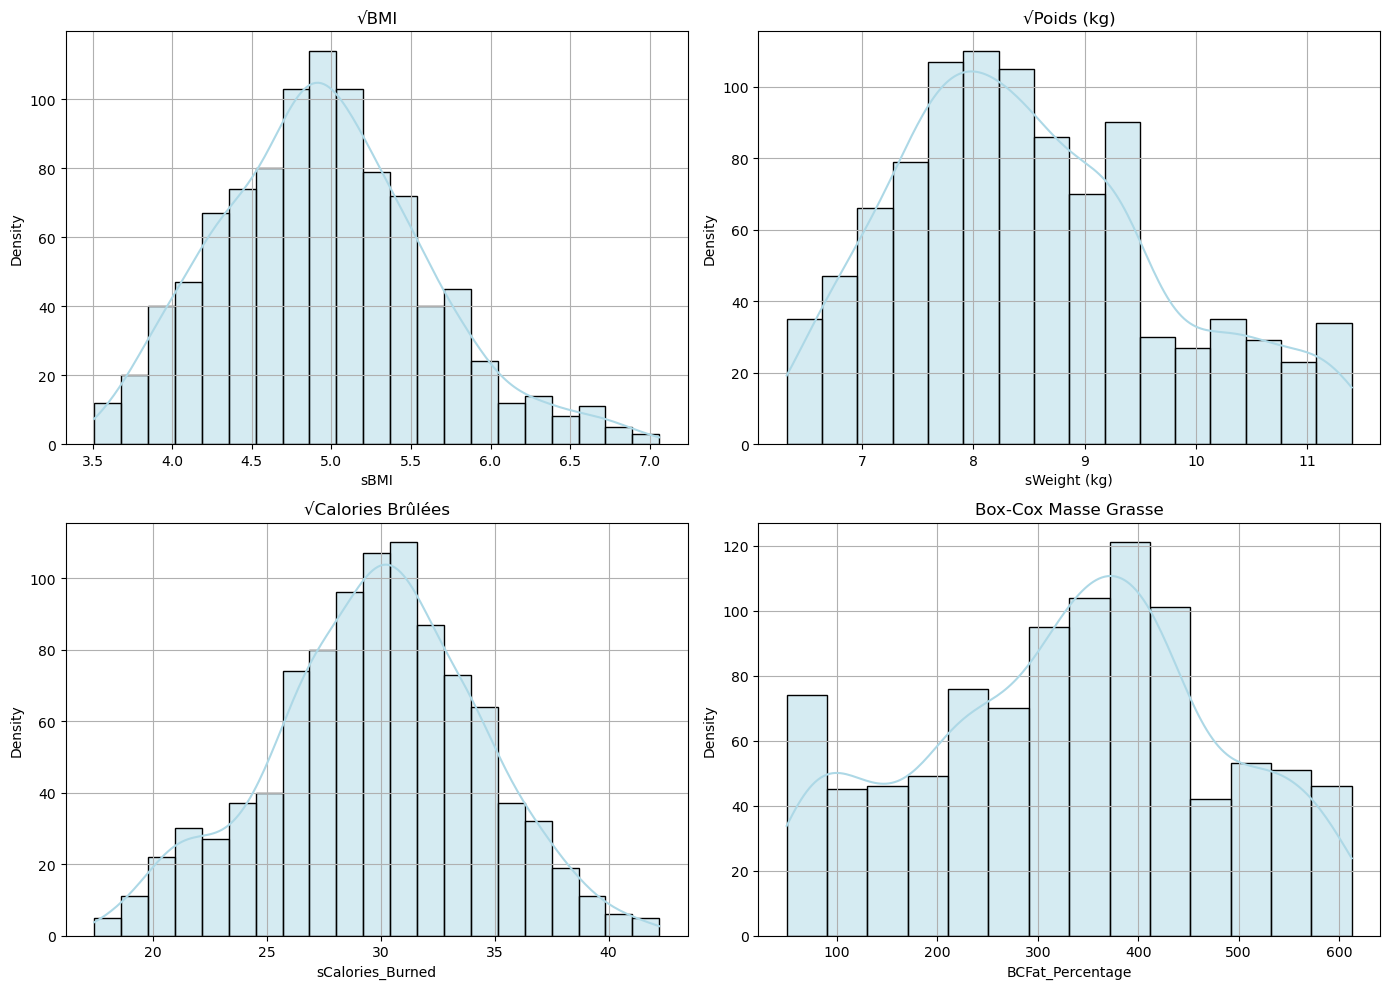

In [ ]:
#transformation des variables continues
# on corrige l'asymétrie de certaines variables via racine carrée
# et transformation de type box-cox

df_norm = dfC.copy()
YC_norm=YC.copy()
df_norm['sBMI'] = np.sqrt(df_norm['BMI'])
df_norm['sWeight (kg)'] = np.sqrt(df_norm['Weight (kg)'])

lambda_ = 2
df_norm['BCFat_Percentage'] = (df_norm['Fat_Percentage'] ** lambda_) / lambda_
YC_norm=np.sqrt(YC)
# visualisation des distributions transformées
plots = [
    ('sBMI', '√BMI'),
    ('sWeight (kg)', '√Poids (kg)'),
    ('sCalories_Burned', '√Calories Brûlées'),
    ('BCFat_Percentage', 'Box-Cox Masse Grasse')
]
#Juste pour le plot 
Plot=df_norm.copy()

Plot["sCalories_Burned"]=YC_norm
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for ax, (col, title) in zip(axs, plots):
    sns.histplot(Plot[col], kde=True, ax=ax, color="lightblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.grid(True)

plt.tight_layout()
plt.show()

On va maintenant séparer nos données en deux échantillons : échantillon d'entrainement et un échantillon test. 

In [ ]:
from sklearn.model_selection import train_test_split  
Lignes_Data=data.shape[0]
Colonnes_Data=data.shape[1]
Nbre_Element=data.size
#Séparation de notre jeu de données en 4 sous ensembles en 2 parties : parti test, parti train
Xc_train,Xc_test,YC_train,YC_test=train_test_split(df_norm,YC,test_size=0.2,random_state=11) #test_size=0.2 indique qu'on prend 20%
#print(type(YC_train))

On va standardiser nos données, indispensables pour une utilisation efficase des algorithmes non linéaires : SVM, réseaux de neuronnes etc ...

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()  
scaler.fit(Xc_train)  
XC_train = scaler.transform(Xc_train)  
# Meme transformation sur le test
XC_test = scaler.transform(Xc_test)

## Procédures de comparaison : 
Afin de comparer les différentes méthodes de comparaisons, on va rappel les  métriques habituels :  
| **Métrique** | **Sensibilité aux outliers** | **Interprétation directe** | **Utilité principale**  |
| ------------ | ---------------------------- | -------------------------- | ----------------------- |
| MSE          | Forte                        | Non                        | Comparaison fine        |
| RMSE         | Forte                        | Oui                        | Compréhension intuitive |
| MAE          | Faible                       | Oui                        | Robustesse              |
| R²           | Moyenne                      | Oui                        | Variance expliquée      |
| R² ajusté    | Moyenne                      | Oui                        | Comparaison de modèles  |

On va aussi tracer les valeurs prédites/valeurs observées ainsi que les résidus pour chaque modèle. Pour les modèles possédant des hyperparamètres à optimiser, on va procéder par validation en utilisant *GridSearchCV* dans *sklearn*. Une fois la meilleur configuration de paramètres trouver, on stockera ce modèle et tout à la fin on va effectuer une comparaison sur données test (ou validation croisée) : 

Fonction *cross_val_score()* 

    -  X : données | y : variable à expliquer | model : modèle à évaluer | cv : nombre de plis. 

    -  Pour i = 1... cv : 

        Divise X,y en cv plis  : 1 plis de validation et les autres pour l'entrainement

        Le modèle est entrainement et tester sur ces plis, on stok le MSE associé

    - Renvoie un tableau avec les cv MSE associé et l'écart-type. 
        


## Bilan procédure général : 
 ### 1. Optimisation des éventuelles hyperparamètres :
 -  Trouver le(s) meilleur(s) hyperparamètre(s) $\alpha*$.

 -  Obtenir le modèle entraîné avec ce(s) $\alpha*$.
 ### 2. Validation croisée finale "extérieure" (sur ce modèle figé avec alpha*) : :

 - Appliquer *cross_val_score()* avec ce modèle et ce(s) $\alpha*$ figé.

 -  Obtenir une estimation non biaisée de ses performances.

In [ ]:
####Dictionnaires des MSE et R² pour comparaison
mse_score_model={}
R2_model={}

mse_score_model_sel={}
R2_model_sel={}

param_opt_models={}

## 2.2 Régression par modèles linéaires 

Cette première partie concerne les modèles linéaires de régression standards, avec ou sans pénalisation. On applique en premier lieu une régression sans pénalisation puis avec une pénalisation Lasso. 

La pénalisation Lasso va nous permettre de faire de la sélection de variables et on va pouvoir observer l'impact d'une sélection de variable sur nos prédictions. 


## Modèle linéaire sans pénalisation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
# Création du modèle linéaire sans régularisation
regLin = LinearRegression()

# Entraînement sur les données d'entraînement
regLin.fit(XC_train, YC_train)

# Prédictions sur l’échantillon test
prev_lin = regLin.predict(XC_test)

# Évaluation
mse_lin = mean_squared_error(YC_test, prev_lin)
r2_lin = r2_score(YC_test, prev_lin)

print("MSE =", mse_lin)
print("R² =", r2_lin)

mse_score_model["Linear Regression"]=mse_lin
R2_model["Linear Regression"]=r2_lin


MSE = 1433.8426130342832
R² = 0.9831584658621288


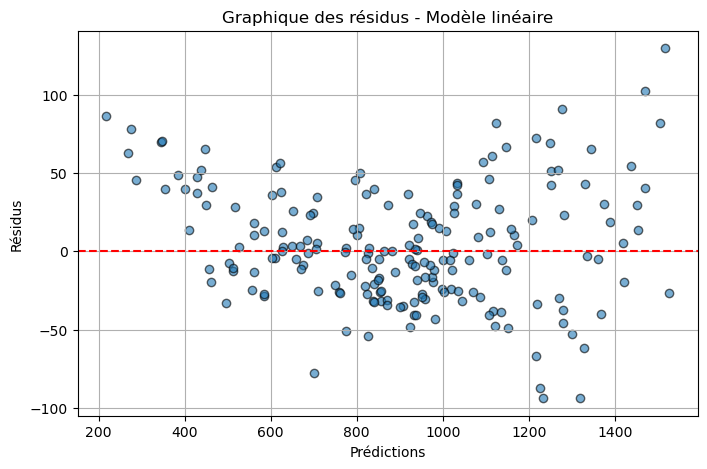

In [ ]:
residus=YC_test-prev_lin
plt.figure(figsize=(8,5))
plt.scatter(prev_lin, residus, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus - Modèle linéaire')
plt.grid(True)
plt.show()

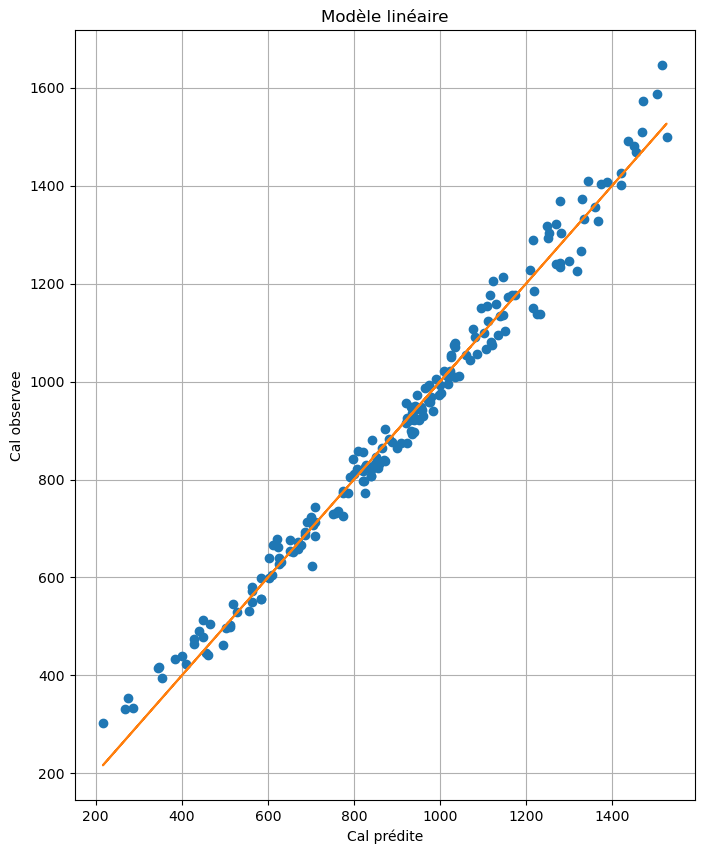

In [ ]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_lin,YC_test,"o")
plt.plot(prev_lin,prev_lin)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Modèle linéaire")
plt.grid(True)
plt.show()

## Pénalisation Lasso

On va maintenant appliquer une pénalisation Lasso avec optimisation de l'hyperparamètre par validation croisée. On va aussi utiliser cette pénalisation pour faire de la sélection de variables. 

In [ ]:
from sklearn.model_selection import GridSearchCV

# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.4,0.5,1.,1.2,1.3,1.4,1.5]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(XC_train, YC_train)
# paramètre optimal
alpha_opt=regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))
prev_Lasso_opt=regLassOpt.predict(XC_test)
print("Meilleur MSE=",mean_squared_error(prev_Lasso_opt,YC_test))


Meilleur R2 = 0.977503, Meilleur paramètre = {'alpha': 1.3}
Meilleur MSE= 1586.5505980228327


In [ ]:
#On stock dans nos dictionnaires
mse_score_model["Lasso"]=mean_squared_error(YC_test,prev_Lasso_opt)
R2_model["Lasso"]=r2_score(YC_test,prev_Lasso_opt)

# Coefficients
regLassoOpt=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso_Opt=regLassoOpt.fit(XC_train,YC_train)
print("Matric des coefficients=",model_lasso_Opt.coef_) #matrice des coefficients

coef = pd.Series(model_lasso_Opt.coef_, index = Xc_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))


Matric des coefficients= [-4.09088889e+01  2.41401871e-13  2.24628604e-01 -0.00000000e+00
  0.00000000e+00 -2.16511389e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  4.94375900e-01 -1.27933668e-01  0.00000000e+00
  0.00000000e+00 -4.00221686e+01  0.00000000e+00  5.27409574e-01
 -0.00000000e+00  8.88551380e+01  6.89504935e-01  2.40691320e+02
 -8.38169449e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.45089225e+00 -0.00000000e+00]
Lasso conserve 13 variables et en supprime 13


In [ ]:
# Variables retenues (coefficients non nuls)
coeff=model_lasso_Opt.coef_
retained_vars = [(var, coef) for var, coef in zip(df_norm.columns, coeff) if coef != 0]

print("\nVariables retenues par Lasso (coefficients non nuls) :n=",len(retained_vars))
for var, coef in retained_vars:
    print(f"{var:30s} -> {coef:.4f}")


Variables retenues par Lasso (coefficients non nuls) :n= 13
Gender_Female                  -> -40.9089
Gender_Male                    -> 0.0000
Workout_Type_Cardio            -> 0.2246
Workout_Type_Yoga              -> -2.1651
Workout_Frequency (days/week)_5 -> 0.4944
Experience_Level_1             -> -0.1279
Age                            -> -40.0222
Height (m)                     -> 0.5274
Avg_BPM                        -> 88.8551
Resting_BPM                    -> 0.6895
Session_Duration (hours)       -> 240.6913
Fat_Percentage                 -> -0.8382
sWeight (kg)                   -> 1.4509


Text(0.5, 1.0, 'Coefficients du modèle lasso')

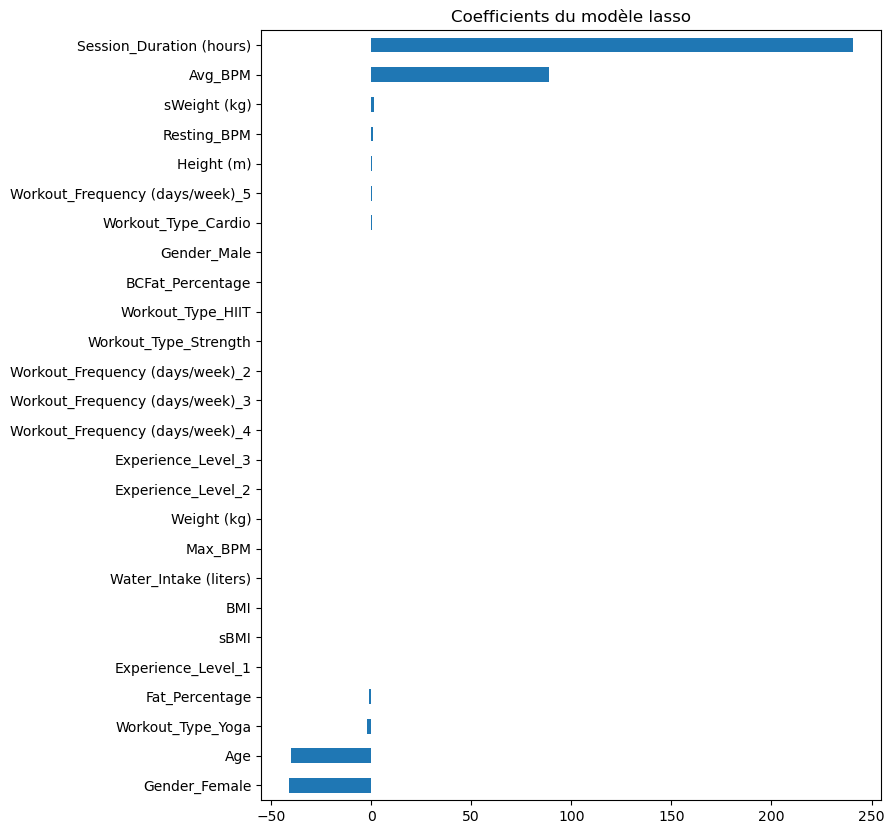

In [ ]:
coef = pd.Series(coeff, index = Xc_train.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

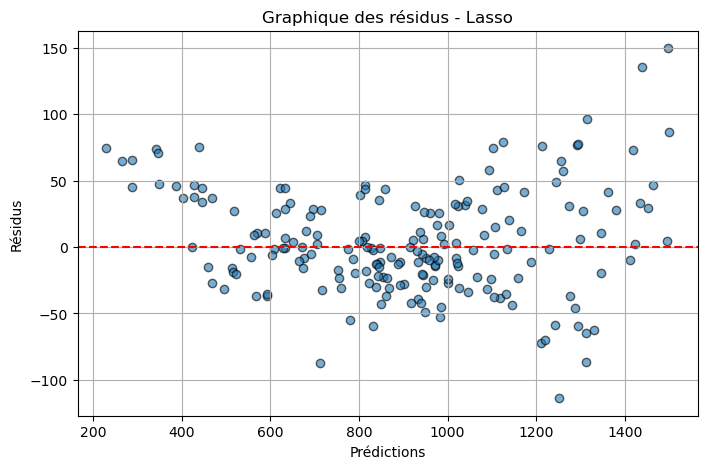

In [ ]:
#print(type(YC_test))*
prev_Lasso_opt=regLassOpt.predict(XC_test)
residus=YC_test-prev_Lasso_opt
plt.figure(figsize=(8,5))
plt.scatter(prev_Lasso_opt, residus, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus - Lasso')
plt.grid(True)
plt.show()

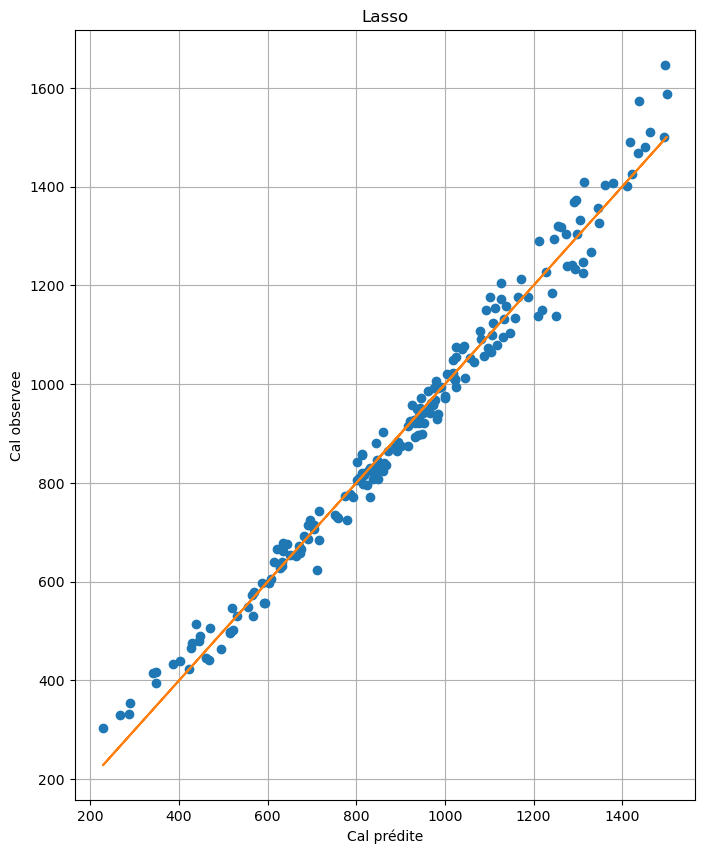

In [ ]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_Lasso_opt,YC_test,"o")
plt.plot(prev_Lasso_opt,prev_Lasso_opt)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Lasso")
plt.grid(True)
plt.show()

### Sélection de variable par Lasso

In [ ]:
# Pour tout le jeu de données
from sklearn.linear_model import Lasso
alpha_opt=regLassOpt.best_params_["alpha"]
print(alpha_opt) #1.3

lasso = Lasso(alpha=alpha_opt)
lasso.fit(XC_train, YC_train)

# Récupère les noms des variables retenues (coefficients ≠ 0)
coef = lasso.coef_
selected_features = [name for name, c in zip(dfC.columns, coef) if c != 0]

print("Variables retenues :", selected_features)
dfC_selected = dfC[selected_features]

#On renormalise nos données 
scaler = StandardScaler()
X_selected = dfC[selected_features]
X_train_sel, X_test_sel = train_test_split(X_selected, test_size=0.2, random_state=11)
XC_train_sel = scaler.fit_transform(X_train_sel)
XC_test_sel = scaler.transform(X_test_sel)


1.3
Variables retenues : ['Gender_Female', 'Gender_Male', 'Workout_Type_Cardio', 'Workout_Type_Yoga', 'Workout_Frequency (days/week)_5', 'Experience_Level_1', 'Age', 'Height (m)', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage']


In [ ]:
regLassOpt_sel=regLasso.fit(XC_train_sel, YC_train)
# paramètre optimal
alpha_opt=regLassOpt_sel.best_params_["alpha"]

param_opt_models['Lasso']=alpha_opt

#print(para_opt)
print("Meilleur R2 = %f (par validation croisée), Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))
prev_lasso_opt_sel=regLassOpt_sel.predict(XC_test_sel)
print("MSE=",mean_squared_error(prev_lasso_opt_sel,YC_test))
print("R2=",r2_score(YC_test,prev_lasso_opt_sel))   

mse_score_model_sel["Lasso"]=mean_squared_error(prev_lasso_opt_sel,YC_test)
R2_model_sel["Lasso"]=r2_score(YC_test,prev_lasso_opt_sel)

Meilleur R2 = 0.977580 (par validation croisée), Meilleur paramètre = {'alpha': 0.5}
MSE= 1588.635162773624
R2= 0.9813403137253289


### Bilan : Lasso

Le fait d'ajouter une pénalisation en norme $L^1$ à notre modèle linéaire nous permet de faire de la sélection de variables. On peut d'ores et déjà quantifier l'impact de certaines variables explicatives notamment : *Session_Duration (hours)* et *Avg_BPM*. 

On peut maintenant comparer l'impact d'une sélection de variables sur les méthodes. 

## 2. kNN et SVR

Dans cette partie on va appliqué une méthode kNN (k-Nearest Neighors) de régression ainsi qu'une SVR (Support Vector Regressor). 

## 2.1 kNN

Voici les hyperparamètres possibles à optimiser dans le cas d'une kNN régression. 

| Paramètre       | Type / Valeurs possibles                    | Description                                                              |
| --------------- | ------------------------------------------- | ------------------------------------------------------------------------ |
| `n_neighbors`   | `int` (ex: `1` à `30`)                      | Nombre de voisins à prendre en compte                                    |
| `weights`       | `['uniform', 'distance']`                   | Poids accordés aux voisins (égaux ou proportionnels à la distance)       |
| `algorithm`     | `['auto', 'ball_tree', 'kd_tree', 'brute']` | Algorithme pour la recherche des plus proches voisins                    |
| `leaf_size`     | `int` (ex: `10` à `100`)                    | Paramètre utilisé dans `kd_tree` ou `ball_tree`                          |
| `p`             | `1` ou `2`                                  | Paramètre de la distance de Minkowski : `1 = manhattan`, `2 = euclidean` |
| `metric`        | `['minkowski', 'euclidean', 'manhattan']`   | Type de distance utilisée                                                |
| `metric_params` | `dict`                                      | Paramètres supplémentaires pour la métrique (rarement utilisé)           |
| `n_jobs`        | `-1` ou `int`                               | Nombre de cœurs utilisés (utile en GridSearch)                           |


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Optimisation de k (nombre de voisins)
param_grid = {
    'n_neighbors': [3, 5, 10,12,15,18],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': [10,20, 30, 40]
}
knn_reg = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, n_jobs=-1)
knnOpt = knn_reg.fit(XC_train, YC_train)

#print(para_opt)
# Meilleur paramètre
print("Meilleur score (cross-val MSE) = %f, Meilleur paramètre = %s" % (1 - knnOpt.best_score_, knnOpt.best_params_))

Meilleur score (cross-val MSE) = 0.334864, Meilleur paramètre = {'leaf_size': 10, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


In [ ]:
# Prédictions sur l’échantillon test
prev_kNN = knnOpt.predict(XC_test)

# Calcul du MSE sur test
mse_kNN = mean_squared_error(YC_test, prev_kNN)
print("MSE sur l'échantillon test : %.2f" % mse_kNN) 
print("R2=",r2_score(YC_test,prev_kNN)) 
mse_score_model["kNN"]= mse_kNN
R2_model["kNN"]=r2_score(YC_test,prev_kNN)


MSE sur l'échantillon test : 22624.89
R2= 0.7342540609291496


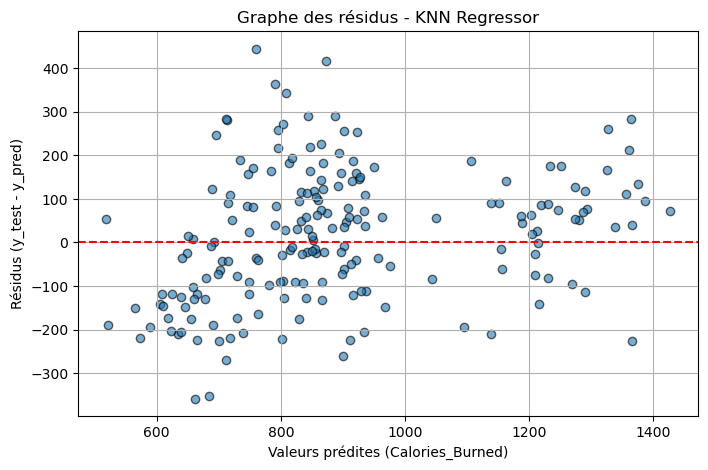

In [ ]:
# Tracé des résidus
residus_kNN = YC_test - prev_kNN
plt.figure(figsize=(8, 5))
plt.scatter(prev_kNN, residus_kNN, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites (Calories_Burned)')
plt.ylabel('Résidus (y_test - y_pred)')
plt.title('Graphe des résidus - KNN Regressor')
plt.grid(True)
plt.show()

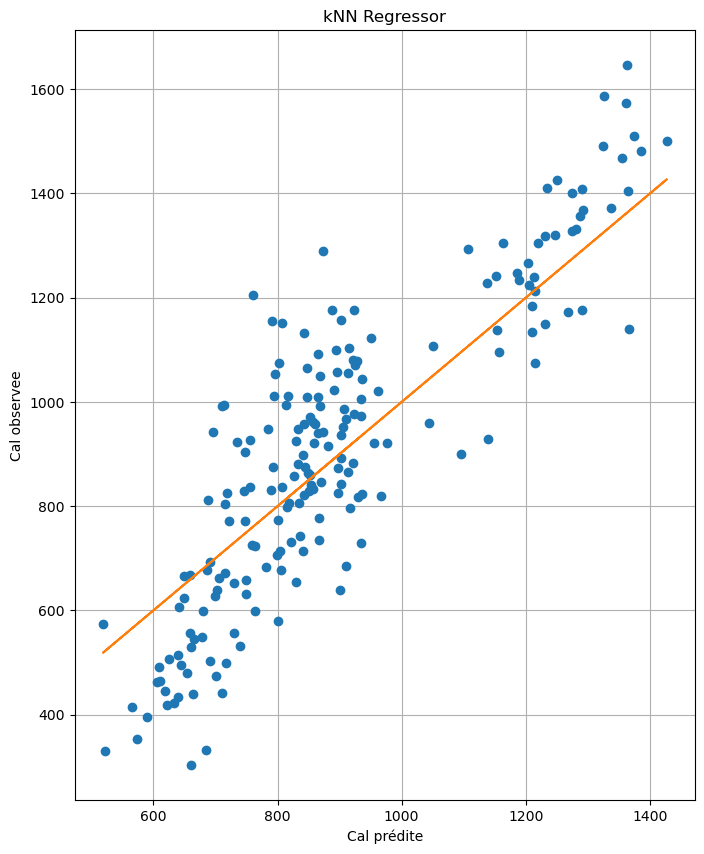

In [ ]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_kNN,YC_test,"o")
plt.plot(prev_kNN,prev_kNN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("kNN Regressor")
plt.grid(True)
plt.show()


On va tester avec notre sélection de variables. 

In [ ]:
# Optimisation de k (nombre de voisins)
knnOpt_sel = knn_reg.fit(XC_train_sel, YC_train)

# Meilleur paramètre
print("Meilleur score (cross-val MSE) = %f, Meilleur paramètre = %s" % (1 - knnOpt_sel.best_score_, knnOpt_sel.best_params_))



Meilleur score (cross-val MSE) = 0.183424, Meilleur paramètre = {'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [ ]:
# Prédictions sur l’échantillon test
prev_kNN_sel = knnOpt.predict(XC_test_sel)

# Calcul du MSE sur test
mse_kNN_sel = mean_squared_error(YC_test, prev_kNN_sel)
print("MSE sur l'échantillon test : %.2f" % mse_kNN_sel) 
# MSE plus basse avec sélection de variable mais tjr haut par rapport aux autres méthodes 
print("R2=",r2_score(YC_test,prev_kNN_sel)) 

mse_score_model_sel["kNN"]= mse_kNN_sel
R2_model_sel["kNN"]=r2_score(YC_test,prev_kNN_sel)
param_opt_models['kNN']=knnOpt_sel.best_params_

MSE sur l'échantillon test : 10960.32
R2= 0.8712630312079874


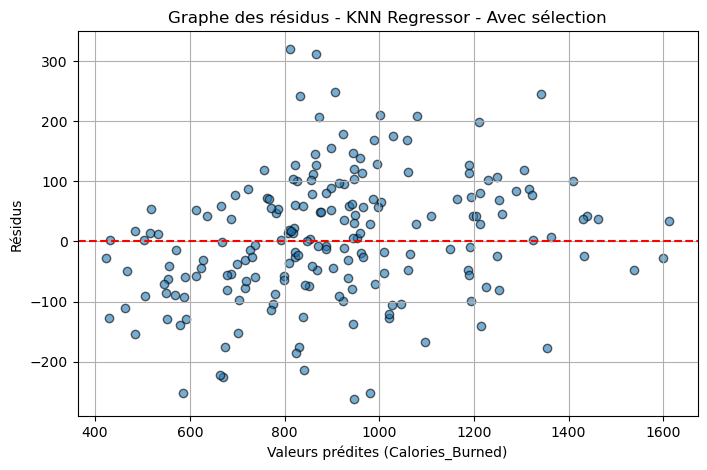

In [ ]:
# Tracé des résidus
residus_kNN_sel = YC_test - prev_kNN_sel
plt.figure(figsize=(8, 5))
plt.scatter(prev_kNN_sel, residus_kNN_sel, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - KNN Regressor - Avec sélection')
plt.grid(True)
plt.show()

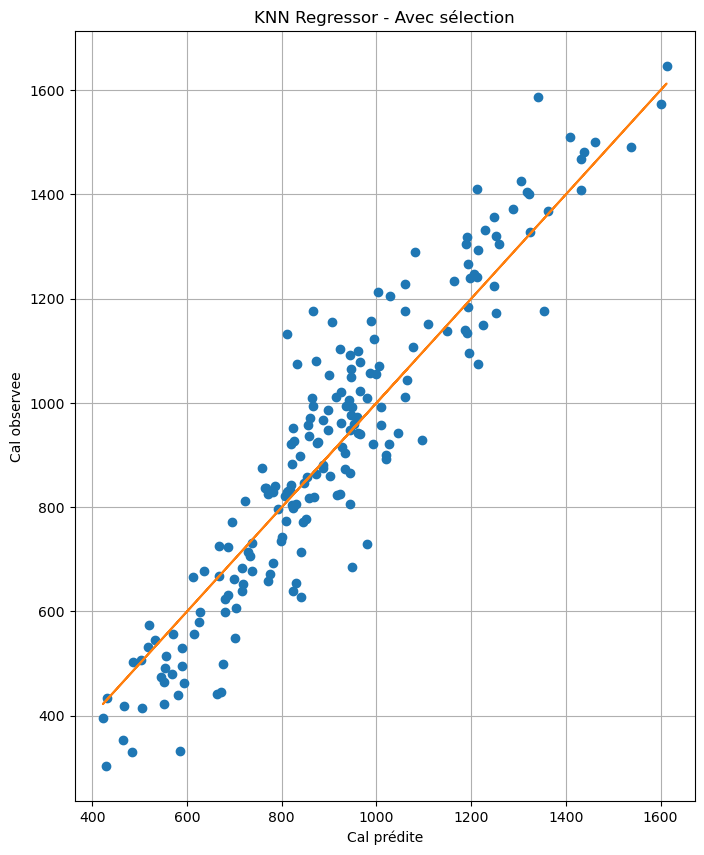

In [ ]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_kNN_sel,YC_test,"o")
plt.plot(prev_kNN_sel,prev_kNN_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("KNN Regressor - Avec sélection")
plt.grid(True)
plt.show()


## 2.2 SVR

Hyperparamètres possibles à optimiser : 
| Paramètre   | Valeurs typiques à tester                | Rôle                                                                                                                    |
| ----------- | ---------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| `C`         | `[0.01, 0.1, 1, 10, 100]`                | Contrôle la **pénalité** sur les erreurs : un **C élevé** => moins de tolérance à l’erreur, risque de surapprentissage. |
| `epsilon`   | `[0.001, 0.01, 0.1, 1]`                  | Définie la **zone autour de la prédiction** dans laquelle aucune pénalité n'est appliquée (le “tube ε-insensitive”).    |
| `kernel`    | `["linear", "poly", "rbf", "sigmoid"]`   | Noyau utilisé pour la projection des données. `rbf` est souvent un bon choix par défaut.                                |
| `gamma`     | `["scale", "auto", 0.001, 0.01, 0.1, 1]` | Utilisé avec les noyaux non linéaires. Contrôle l’influence d’un seul point d’entraînement.                             |
| `degree`    | `[2, 3, 4, 5]` *(si kernel='poly')*      | Degré du polynôme pour le noyau polynomial.                                                                             |
| `shrinking` | `[True, False]`                          | Active ou non l’heuristique de **réduction du vecteur de support**.                                                     |
| `tol`       | `[1e-3, 1e-4]`                           | Critère de **tolérance** d’arrêt.                                                                                       |


Le paramètre C contrôle le compromis entre biais et variance :

    Petit C → le modèle accepte plus d'erreur à l'intérieur du tube ε, ce qui donne une solution plus lisse (plus de biais, moins de variance).

    Grand C → le modèle pénalise fortement les erreurs, cherchant à prédire le plus proche possible des vraies valeurs (moins de biais, mais plus de variance).

In [ ]:
from sklearn.svm import SVR
#Au cas où, important pour cette méthode
scaler = StandardScaler()
XC_train = scaler.fit_transform(XC_train)
XC_test = scaler.transform(XC_test)
#optimisation des autres paramètres 
param_grid = { 
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 1,2],
    "kernel": ["rbf"],
    "gamma": ["scale", "auto"]
}

svr = GridSearchCV(SVR(), param_grid, cv=5, n_jobs=-1)
svrOpt = svr.fit(XC_train, YC_train)
print("Sans SV, Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt.best_score_, svrOpt.best_params_))


Sans SV, Meilleur score = 0.050240, Meilleur paramètre = {'C': 100, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# erreur de régression sur le test
1-svrOpt.score(XC_test,YC_test)

0.027926146407164176

In [ ]:
# Prédictions sur le jeu de test
pred_svr = svrOpt.predict(XC_test)
# Calcul des résidus
residus_svr = YC_test - pred_svr
# Calcul du MSE
mse_svr = mean_squared_error(YC_test, pred_svr)
print("MSE sur l'échantillon test (SVR) : %.2f" % mse_svr)
print("R2=",r2_score(YC_test,pred_svr)) 

mse_score_model["SVR"]=mse_svr
R2_model["SVR"]=r2_score(YC_test,pred_svr)



MSE sur l'échantillon test (SVR) : 2377.56
R2= 0.9720738535928358


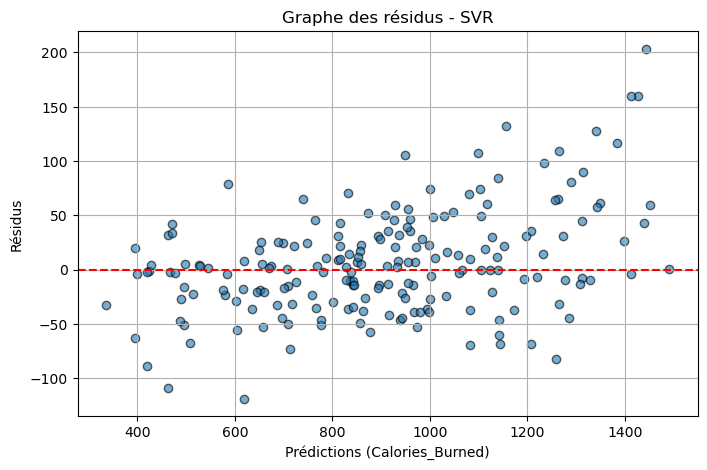

In [ ]:
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(pred_svr, residus_svr, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - SVR')
plt.grid(True)
plt.show()

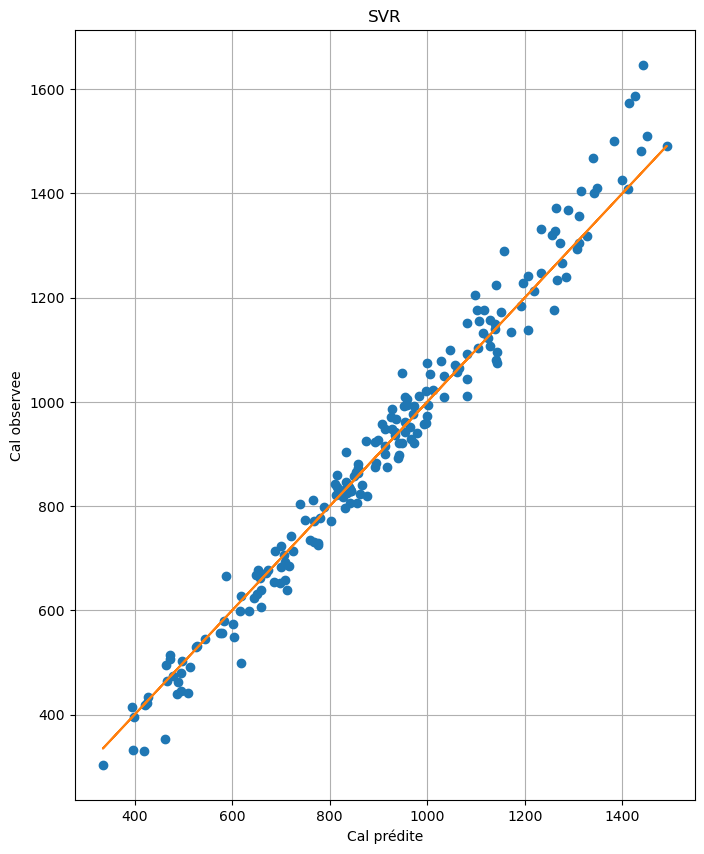

In [ ]:
plt.plot(pred_svr,YC_test,"o")
plt.plot(pred_svr,pred_svr)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("SVR")
plt.grid(True)
plt.show()

### SVR avec sélection de variables

In [ ]:
svrOpt_sel=svr.fit(XC_train_sel,YC_train)
print("Avec SV, Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt_sel.best_score_, svrOpt_sel.best_params_))


Avec SV, Meilleur score = 0.037810, Meilleur paramètre = {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# erreur de régression sur le test
1-svrOpt_sel.score(XC_test_sel,YC_test)

0.022413349919811476

In [ ]:
# Prédictions sur le jeu de test
pred_svr_sel = svrOpt_sel.predict(XC_test_sel)

# Calcul des résidus
residus_svr_sel = YC_test - pred_svr_sel

# Calcul du MSE
mse_svr_sel = mean_squared_error(YC_test, pred_svr_sel)
print("Avec SV, MSE sur l'échantillon test (SVR) : %.2f" % mse_svr_sel)
print("Avec SV, R2=",r2_score(YC_test,pred_svr_sel)) 
param_opt_models["SVR"]=svrOpt_sel.best_params_
mse_score_model_sel["SVR"]=mse_svr_sel
R2_model_sel["SVR"]=r2_score(YC_test,pred_svr_sel)

Avec SV, MSE sur l'échantillon test (SVR) : 1908.21
Avec SV, R2= 0.9775866500801885


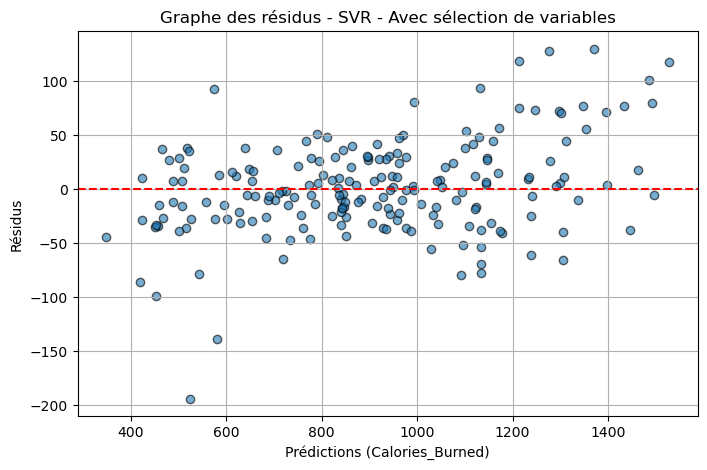

In [ ]:
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(pred_svr_sel, residus_svr_sel, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - SVR - Avec sélection de variables')
plt.grid(True)
plt.show()

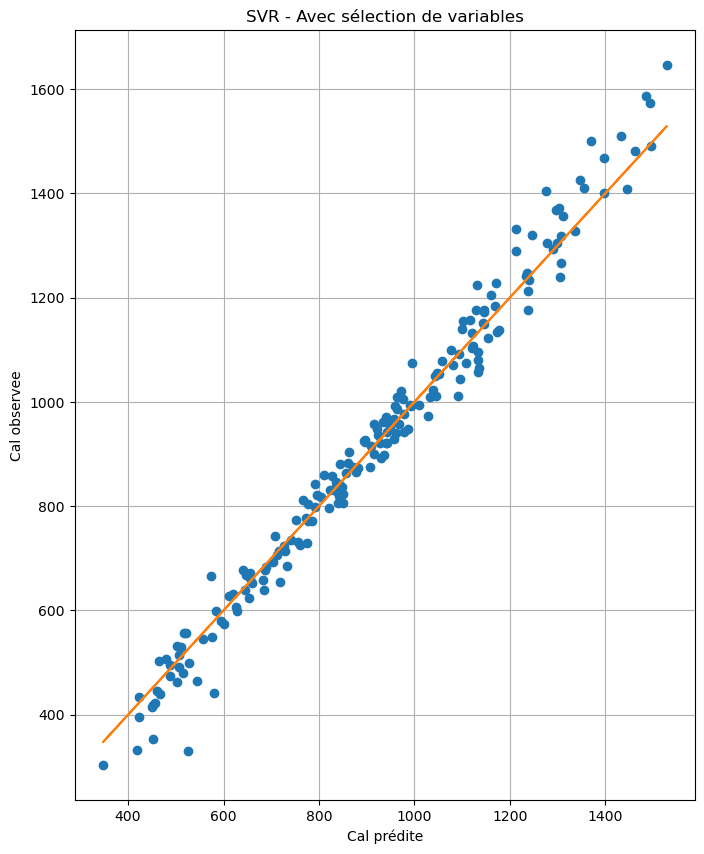

In [ ]:
plt.plot(pred_svr_sel,YC_test,"o")
plt.plot(pred_svr_sel,pred_svr_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("SVR - Avec sélection de variables")
plt.grid(True)
plt.show()

### Bilan : 
Les deux modèles offrents des performances plutôt satisfaisante, même si kNN introduit pas mal de variances. 

On constate que kNN regressor est moins précis que SVR, en se basant sur les R² et les MSE. Dans les deux cas, la sélection de variables mènent à une amélioration des performances de prédictions. 
 


# Arbre de régression 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Optimisation de la profondeur de l'arbre
param = [{"max_depth": list(range(2, 10))}]
tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(XC_train, YC_train)

# Affichage du meilleur paramètre
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_, treeOpt.best_params_))
# Prédictions sur le jeu de test
y_pred_tree = treeOpt.predict(XC_test)

# MSE
mse_tree = mean_squared_error(YC_test, y_pred_tree)
print("MSE sur l'échantillon test (arbre de régression) : %.2f" % mse_tree)
print("R2=",r2_score(YC_test,y_pred_tree)) 


Meilleur score = 0.078745, Meilleur paramètre = {'max_depth': 8}
MSE sur l'échantillon test (arbre de régression) : 5834.50
R2= 0.9314695508514917


MSE sur l'échantillon test : 5387.6668
R2= 0.9367178981762962


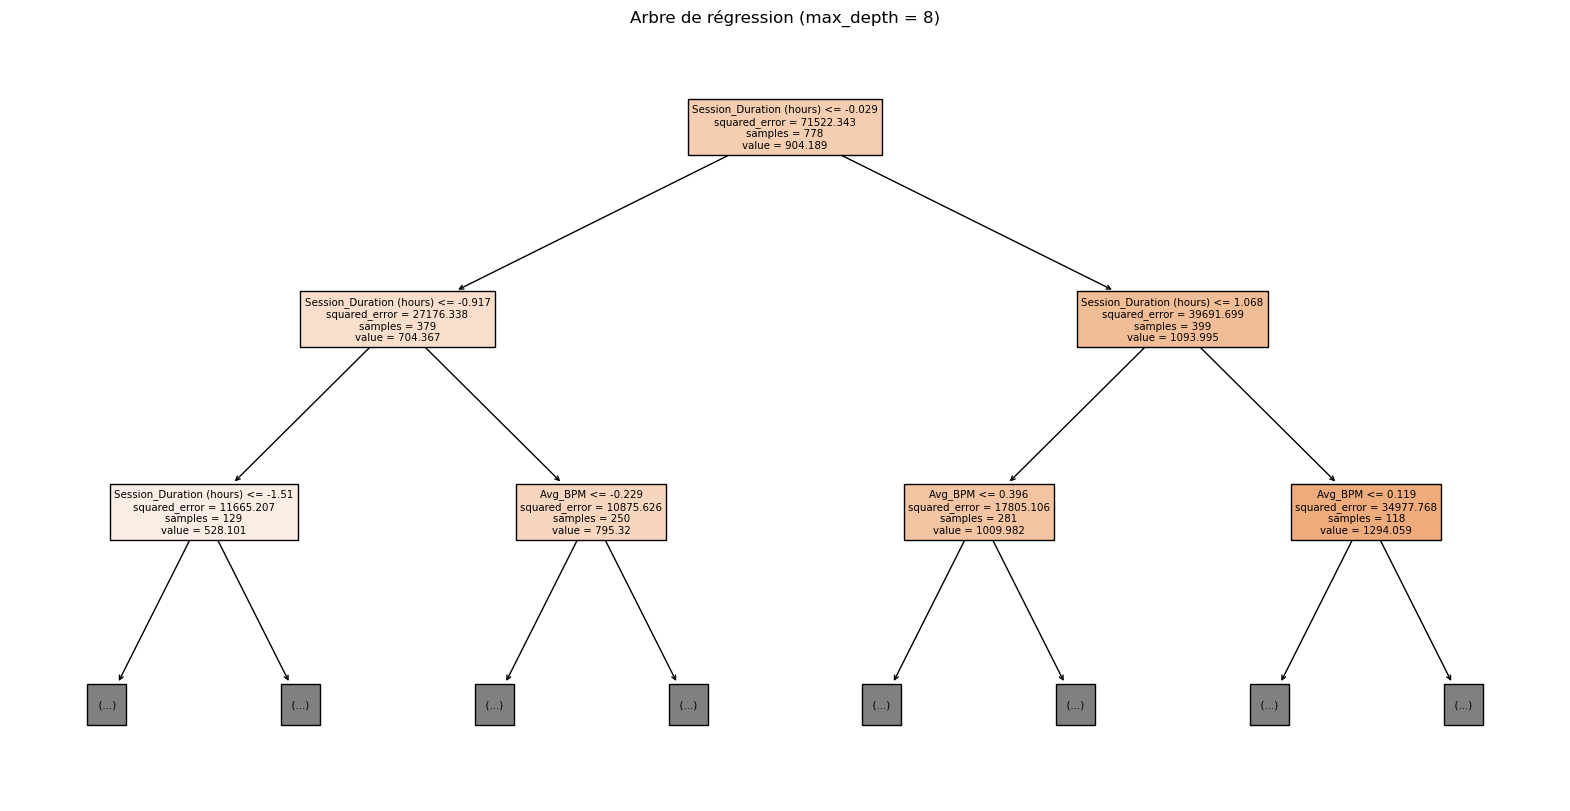

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Ré-entraînement de l'arbre avec la profondeur optimale trouvée
treeG = DecisionTreeRegressor(max_depth=treeOpt.best_params_['max_depth']) # on ré entraine pour avoir plus de controle 
treeG.fit(XC_train, YC_train)

# Prédictions sur l'échantillon test
y_pred_tree = treeG.predict(XC_test)
# Calcul du MSE
mse_tree = mean_squared_error(YC_test, y_pred_tree)
print(f"MSE sur l'échantillon test : {mse_tree:.4f}")
print("R2=",r2_score(YC_test,y_pred_tree))

mse_score_model["Regressor Tree"]=mean_squared_error(YC_test, y_pred_tree)
R2_model["Regressor Tree"]=r2_score(YC_test,y_pred_tree)

 
# Tracé de l'arbre
plt.figure(figsize=(20, 10))  # Ajuste la taille pour la lisibilité
plot_tree(treeG, feature_names=dfC.columns.tolist(), filled=True, max_depth=2)
plt.title("Arbre de régression (max_depth = %d)" % treeOpt.best_params_['max_depth'])
plt.show()


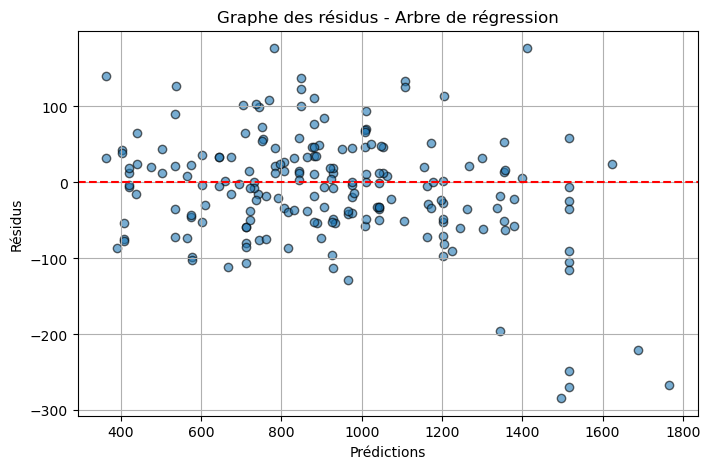

In [ ]:

# Prédictions sur l'échantillon test
y_pred_tree = treeG.predict(XC_test)

# Calcul des résidus
residus_tree  = YC_test - y_pred_tree

# Tracé des résidus
plt.figure(figsize=(8,5))
plt.scatter(y_pred_tree, residus_tree , alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Arbre de régression')
plt.grid(True)
plt.show()

### Remarque : 

Les résidus n'ont pas leur formes habituelles de segments verticaux (sauf à quelque endroit), cela est due qu'on accorde une profondeur max de 8 ce qui tend a rendre unique les prédictions. C'est ce dernier aspect qui rend la distributions presque "aléatoire". 

Néanmoins, les résidus sont toujours centrés autour de 0 et compris dans un tube pour la plupart des points.  

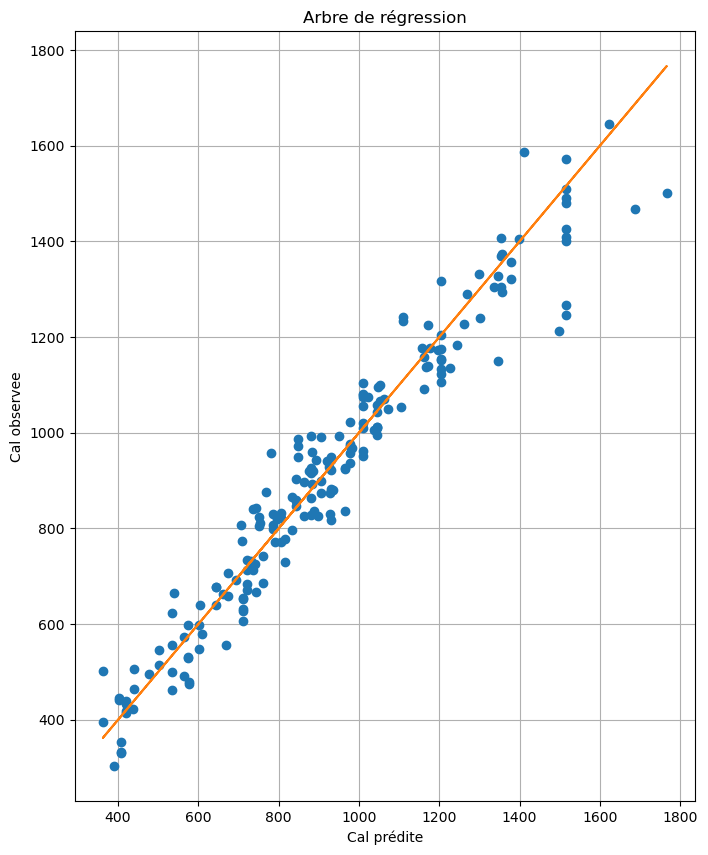

In [ ]:
plt.plot(y_pred_tree,YC_test,"o")
plt.plot(y_pred_tree,y_pred_tree)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Arbre de régression")
plt.grid(True)
plt.show()

### Avec sélection de variables

In [ ]:
#Entrainement avec sélection
treeOpt_sel = tree.fit(XC_train_sel, YC_train)

# Affichage du meilleur paramètre
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt_sel.best_score_, treeOpt_sel.best_params_))
# Prédictions sur le jeu de test
y_pred_tree_sel = treeOpt.predict(XC_test_sel)

# MSE
mse_tree_sel = mean_squared_error(YC_test, y_pred_tree_sel)
print("MSE sur l'échantillon test (arbre de régression) : %.2f" % mse_tree_sel)
print("R2=",r2_score(YC_test,y_pred_tree_sel)) 

mse_score_model_sel['Regressor Tree']=mse_tree_sel
R2_model_sel["Regressor Tree"]=r2_score(YC_test,y_pred_tree_sel)

param_opt_models["Regressor Tree"]=treeOpt_sel.best_params_


Meilleur score = 0.064132, Meilleur paramètre = {'max_depth': 9}
MSE sur l'échantillon test (arbre de régression) : 4226.49
R2= 0.9503568131558295


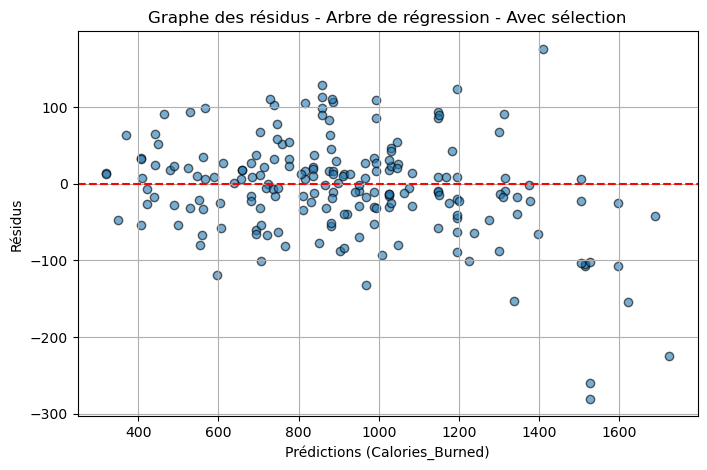

In [ ]:
# Tracé des résidus
# Calcul des résidus
residus_tree_sel = YC_test - y_pred_tree_sel
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_tree_sel, residus_tree_sel, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Arbre de régression - Avec sélection')
plt.grid(True)
plt.show()

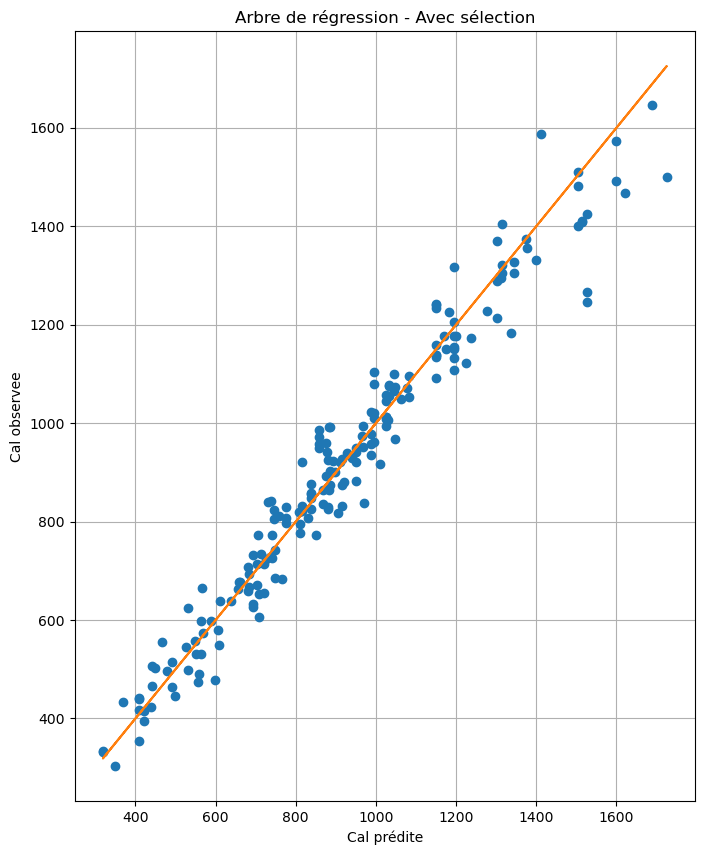

In [ ]:
plt.plot(y_pred_tree_sel,YC_test,"o")
plt.plot(y_pred_tree_sel,y_pred_tree_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Arbre de régression - Avec sélection")
plt.grid(True)
plt.show()

# 4 Forêt aléatoire 

Meilleur score = 0.032262, Meilleur paramètre = {'max_features': 21}
MSE sur échantillon test = 1790.4186
R2= 0.9789702186048947
MSE sur échantillon test (Avec sélection) = 1407.8286
R2 (Avec sélection)= 0.9834640189891055


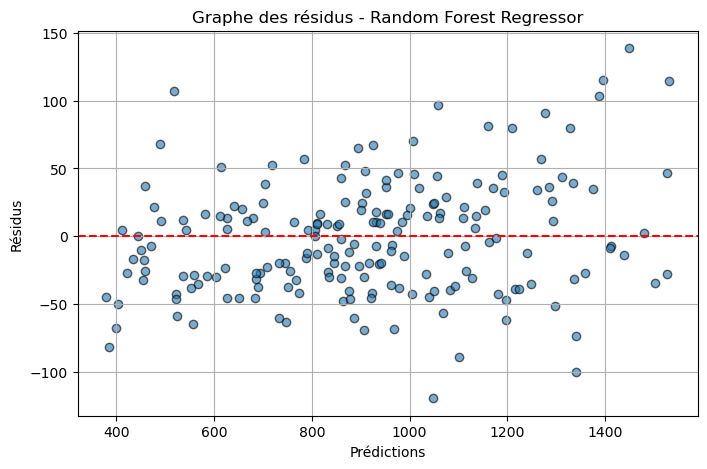

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param = [{"max_features": list(range(5, 22))}]
rf = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42,oob_score=True),
                  param, cv=5, n_jobs=-1)
rfOpt = rf.fit(XC_train, YC_train)

print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))

# Prédiction sur l'échantillon test
pred_Rtree = rfOpt.predict(XC_test)

# erreur de prévision sur le test
1-rfOpt.score(XC_test,YC_test)

#On fait sélection de variables directement
rfOpt_sel=rf.fit(XC_train_sel,YC_train)
pred_Rtree_sel=rfOpt_sel.predict(XC_test_sel)

# erreur de prévision sur le test
1-rfOpt_sel.score(XC_test_sel,YC_test)

# Calcul du MSE sur l'échantillon test
mse_Random = mean_squared_error(YC_test, pred_Rtree)
print(f"MSE sur échantillon test = {mse_Random:.4f}")
print("R2=",r2_score(YC_test,pred_Rtree)) 

mse_score_model["Random forest"]=mse_Random
R2_model["Random forest"]=r2_score(YC_test,pred_Rtree)

mse_Random_sel=mean_squared_error(YC_test, pred_Rtree_sel)
print(f"MSE sur échantillon test (Avec sélection) = {mse_Random_sel:.4f}")
print("R2 (Avec sélection)=",r2_score(YC_test,pred_Rtree_sel)) 

mse_score_model_sel["Random forest"]=mse_Random_sel
R2_model_sel["Random forest"]=r2_score(YC_test,pred_Rtree_sel)
param_opt_models["Random forest"]=rfOpt_sel.best_params_
# Tracé des résidus
residus_Rtree = YC_test - pred_Rtree
plt.figure(figsize=(8,5))
plt.scatter(pred_Rtree, residus_Rtree, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Random Forest Regressor')
plt.grid(True)
plt.show()

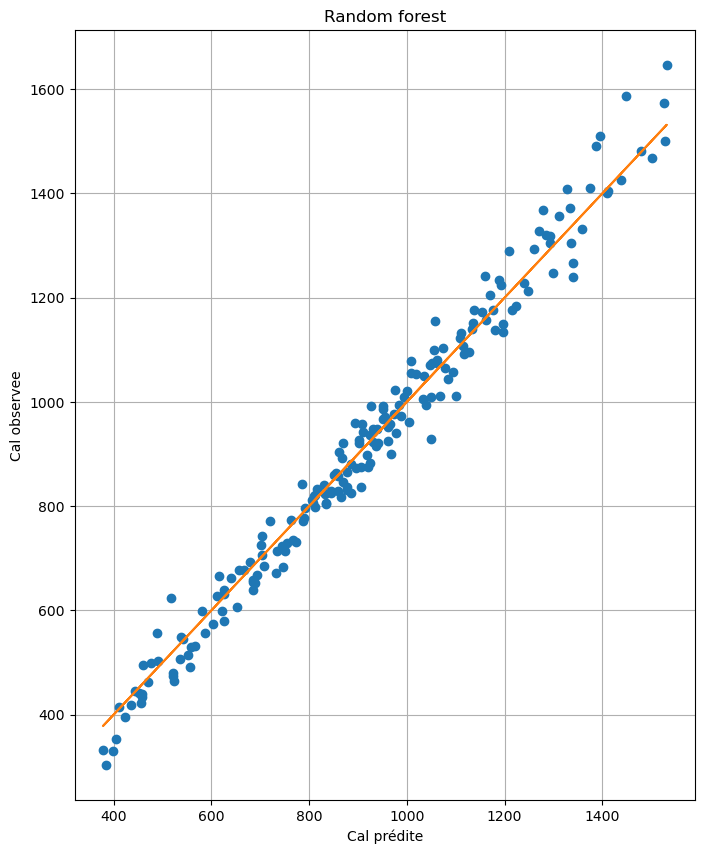

In [ ]:
plt.plot(pred_Rtree,YC_test,"o")
plt.plot(pred_Rtree,pred_Rtree)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Random forest")
plt.grid(True)
plt.show()

In [ ]:
para_opt=rfOpt.best_params_["max_features"]
rf = RandomForestRegressor(n_estimators=100, max_features=para_opt, random_state=42)
rfFit = rf.fit(XC_train, YC_train)

# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1] # on tri par ordre décroissant les indices associés

# on affiche l'importance par variables
i=1
for f in range(XC_train.shape[1]):
    print(i,df_norm.columns[indices[f]], importances[indices[f]])
    i=i+1

1 Session_Duration (hours) 0.4685918515017003
2 Experience_Level_3 0.11983265359589679
3 Avg_BPM 0.09509219812708028
4 Fat_Percentage 0.08892295288438787
5 BCFat_Percentage 0.06507811128908599
6 Experience_Level_1 0.0375038362943299
7 Age 0.022513384207355065
8 Experience_Level_2 0.017415984611822546
9 sWeight (kg) 0.01037973128210974
10 Weight (kg) 0.009516405211508653
11 Height (m) 0.009449515863841702
12 Water_Intake (liters) 0.008803213173473604
13 sBMI 0.007913662479830778
14 BMI 0.007487724923223473
15 Resting_BPM 0.007338789293137346
16 Max_BPM 0.006121721585941058
17 Gender_Male 0.004570124817923557
18 Gender_Female 0.004546698189003975
19 Workout_Type_Strength 0.0018522188684087697
20 Workout_Frequency (days/week)_2 0.0017102829630356818
21 Workout_Frequency (days/week)_4 0.0012259917448426503
22 Workout_Type_Cardio 0.001132278419693148
23 Workout_Type_Yoga 0.0010226608409351723
24 Workout_Type_HIIT 0.0008784146526330343
25 Workout_Frequency (days/week)_3 0.0006473696975222038

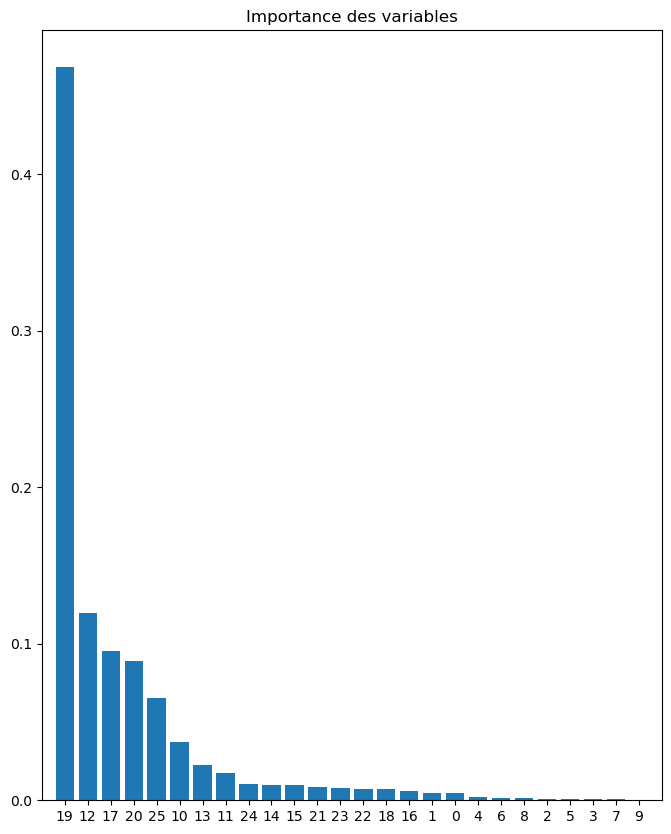

In [ ]:
# Graphe des importances
plt.figure()
plt.title("Importance des variables")
plt.bar(range(XC_train.shape[1]), importances[indices])
plt.xticks(range(XC_train.shape[1]), indices)
plt.xlim([-1, XC_train.shape[1]])
plt.show()

## Boosting : XGBOOST

On va améliorer la méthode Random Forest avec un méthode de boosting. 

| Hyperparamètre          | Description                                                 | Valeurs courantes à tester      |
| ----------------------- | ----------------------------------------------------------- | ------------------------------- |
| `n_estimators`          | Nombre d’arbres dans la forêt                               | 50, 100, 200, 500               |
| `max_depth`             | Profondeur maximale des arbres                              | 3, 4, 5, 6, 8                   |
| `learning_rate` (eta)   | Taux d’apprentissage (contrôle la taille des pas)           | 0.01, 0.05, 0.1, 0.2            |
| `subsample`             | Fraction d’échantillons utilisés pour chaque arbre          | 0.6, 0.8, 1.0                   |
| `colsample_bytree`      | Fraction des features utilisés par arbre                    | 0.5, 0.7, 1.0                   |
| `gamma`                 | Gain minimal requis pour faire une nouvelle division        | 0, 0.1, 0.2, 1                  |
| `min_child_weight`      | Poids minimal requis dans un nœud                           | 1, 3, 5                         |
| `reg_alpha`             | Coefficient de régularisation L1                            | 0, 0.01, 0.1                    |
| `reg_lambda`            | Coefficient de régularisation L2                            | 1, 1.5, 2                       |
| `scale_pos_weight`      | Pour traiter déséquilibre des classes (rare en régression)  | 1 (souvent pas utilisé)         |
| `objective`             | Fonction objectif (ex: 'reg\:squarederror' pour régression) | Fixé en général pour régression |
| `seed` / `random_state` | Fixe la graine aléatoire pour reproductibilité              | Valeur fixe, ex: 42             |


Meilleur score =  439.7899351279055
Meilleur paramètre =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
MSE sur test = 340.8314
R2 sur test = 0.9960


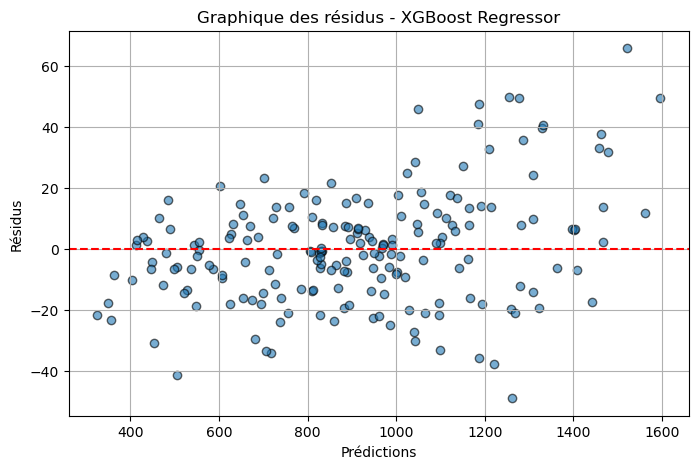

In [ ]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Création du modèle XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Grille d'hyperparamètres à tester
param_grid = {
    "max_depth": [3, 5, 7, 9],        # profondeur des arbres
    "learning_rate": [0.01, 0.1, 0.2], # taux d'apprentissage
    "n_estimators": [100, 200, 300]    # nombre d'arbres
}

# Recherche par validation croisée
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(XC_train, YC_train)

# Meilleurs paramètres et score
print("Meilleur score = ", -grid_search.best_score_)
print("Meilleur paramètre = ", grid_search.best_params_)

# Meilleur modèle
best_model = grid_search.best_estimator_

# Prédictions sur le jeu test
y_pred_Boost = best_model.predict(XC_test)

# Calcul MSE et R2
mse_boost = mean_squared_error(YC_test, y_pred_Boost)
r2_boost = r2_score(YC_test, y_pred_Boost)
print(f"MSE sur test = {mse_boost:.4f}")
print(f"R2 sur test = {r2_boost:.4f}")

mse_score_model["XGBOOST"]=mse_boost
R2_model["XGBOOST"]=r2_boost

# Graphe des résidus
residus = YC_test - y_pred_Boost
plt.figure(figsize=(8,5))
plt.scatter(y_pred_Boost, residus, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus - XGBoost Regressor')
plt.grid(True)
plt.show()

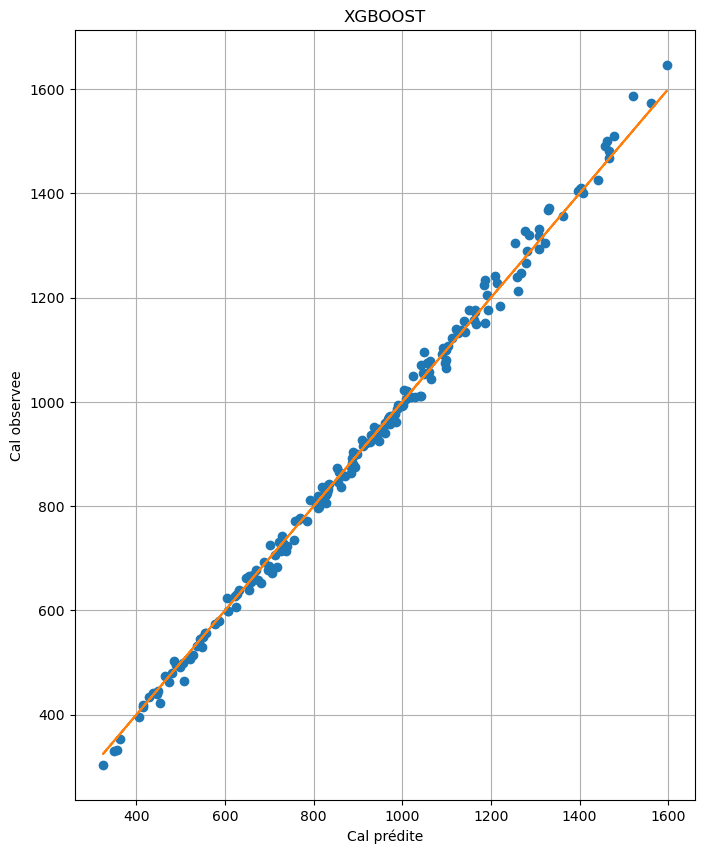

In [ ]:
plt.plot(y_pred_Boost,YC_test,"o")
plt.plot(y_pred_Boost,y_pred_Boost)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("XGBOOST")
plt.grid(True)
plt.show()

### Avec sélection de variables

Meilleur score =  397.1670045108096
Meilleur paramètre =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
MSE sur test = 333.3953
R2 sur test = 0.9961


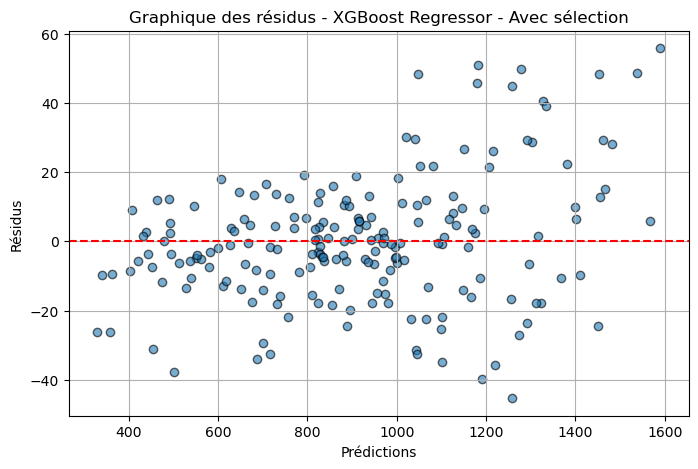

In [ ]:
grid_search.fit(XC_train_sel, YC_train)

# Meilleurs paramètres et score
print("Meilleur score = ", -grid_search.best_score_)
print("Meilleur paramètre = ", grid_search.best_params_)

# Meilleur modèle
best_model = grid_search.best_estimator_

# Prédictions sur le jeu test
y_pred_Boost_sel = best_model.predict(XC_test_sel)

# Calcul MSE et R2
mse_boost_sel = mean_squared_error(YC_test, y_pred_Boost_sel)
r2_boost_sel = r2_score(YC_test, y_pred_Boost_sel)
print(f"MSE sur test = {mse_boost_sel:.4f}")
print(f"R2 sur test = {r2_boost_sel:.4f}")

mse_score_model_sel["XGBOOST"]=mse_boost_sel
R2_model_sel["XGBOOST"]=r2_boost_sel

param_opt_models["XGBOOST"]=grid_search.best_params_
# Graphe des résidus
residus = YC_test - y_pred_Boost_sel
plt.figure(figsize=(8,5))
plt.scatter(y_pred_Boost_sel, residus, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus - XGBoost Regressor - Avec sélection')
plt.grid(True)
plt.show()

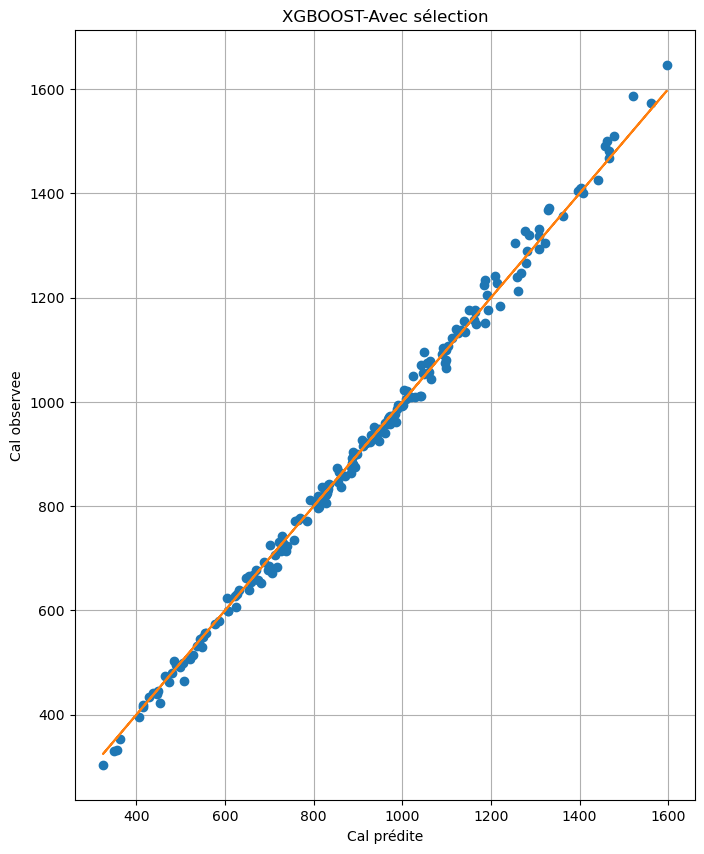

In [ ]:
plt.plot(y_pred_Boost,YC_test,"o")
plt.plot(y_pred_Boost,y_pred_Boost)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("XGBOOST-Avec sélection")
plt.grid(True)
plt.show()

### Conclusion : (Arbre de décision et Random Forest (+) boosting)

Sans surprise Random Forest présente des meilleurs performances que l'arbre de décision. On peut encore faire mieux avec un Boost. 
En effet, on obtient de très bons résultats avec une méthode Random Forest doublé d'un boosting (via *xgboost*). Le fait d'optimiser d'une grille de paramètres au lieu de juste la profondeur permet d'obtenir des meilleurs résultats. 

On constate à nouveau que la sélection de variables offrent un gain de performances plutôt important notamment pour l'Arbre de décision et Random Forest. 

Le boosting affiche des performances plus hautes que toutes les méthodes précédentes une précision nettement meilleurs que les autres méthodes. 

Cette méthode est pour le moment celle qui obtient les meilleurs résultats avec . On va encore tester la prédiction par réseaux de neuronnes en utilisant *sklearn* puis avec architectures plus profondes avec *tensorflow*.

# 5 Réseaux de Neuronnes

| Paramètre            | Type / Valeurs possibles                        | Rôle                                                             |
| -------------------- | ----------------------------------------------- | ---------------------------------------------------------------- |
| `hidden_layer_sizes` | `[(50,), (100,), (50,50), (100,50), (100,100)]` | Architecture du réseau (nombres de neurones par couche cachée)   |
| `activation`         | `["identity", "logistic", "tanh", "relu"]`      | Fonction d'activation dans les couches cachées                   |
| `solver`             | `["lbfgs", "sgd", "adam"]`                      | Algorithme d’optimisation                                        |
| `alpha`              | `[0.0001, 0.001, 0.01, 0.1, 1]`                 | Terme de régularisation L2                                       |
| `batch_size`         | `["auto", 16, 32, 64, 128]`                     | Taille des mini-lots pour SGD ou adam                            |
| `learning_rate`      | `["constant", "invscaling", "adaptive"]`        | Stratégie d’adaptation du taux d’apprentissage                   |
| `learning_rate_init` | `[0.001, 0.01, 0.1]`                            | Taux d’apprentissage initial                                     |
| `max_iter`           | `[200, 300, 500, 1000]`                         | Nombre maximal d’itérations                                      |
| `early_stopping`     | `[True, False]`                                 | Active un arrêt automatique si la validation ne s'améliore plus  |
| `tol`                | `[1e-4, 1e-3]`                                  | Tolérance pour l’arrêt de l’optimisation                         |
| `momentum`           | `[0.9, 0.95, 0.99]` (si `solver='sgd'`)         | Moment utilisé lors de l’optimisation par SGD                    |
| `n_iter_no_change`   | `[5, 10, 20]`                                   | Nombre d’itérations sans amélioration pour `early_stopping=True` |


In [ ]:
from sklearn.neural_network import MLPRegressor

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Meilleur score = 0.981235
Meilleur paramètre = {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 25), 'learning_rate_init': 0.01, 'solver': 'adam'}
MSE sur test = 1455.3434
R2= 0.9829059233472008


c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


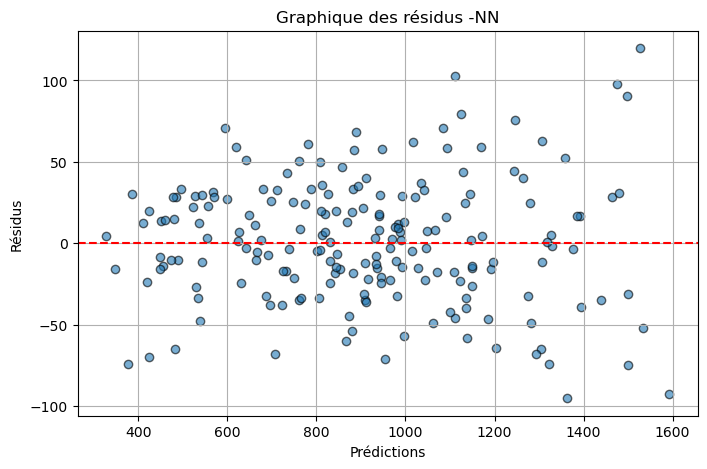

In [ ]:
#Système de paramètres pour l'optimisation
param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (100, 50), (50, 25),(150,)], 
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
}

mlp = MLPRegressor(max_iter=300, random_state=42) 

grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)#validation croisée pour trouver les paramètres opti
grid_search.fit(XC_train, YC_train)

print("Meilleur score = %f" % (grid_search.best_score_)) # score moyen obtenu en validation croisée 
print("Meilleur paramètre =", grid_search.best_params_)

# Évaluation sur test
best_model = grid_search.best_estimator_
pred_NN = best_model.predict(XC_test)
mse_NN = mean_squared_error(YC_test, pred_NN)
print(f"MSE sur test = {mse_NN:.4f}")
print("R2=",r2_score(YC_test,pred_NN))   # R2 sur l'échantillon test 

mse_score_model["NN"]=mse_NN
R2_model["NN"]=r2_score(YC_test,pred_NN)


residuals = YC_test - pred_NN
plt.figure(figsize=(8,5))
plt.scatter(pred_NN, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus -NN')
plt.grid(True)
plt.show()

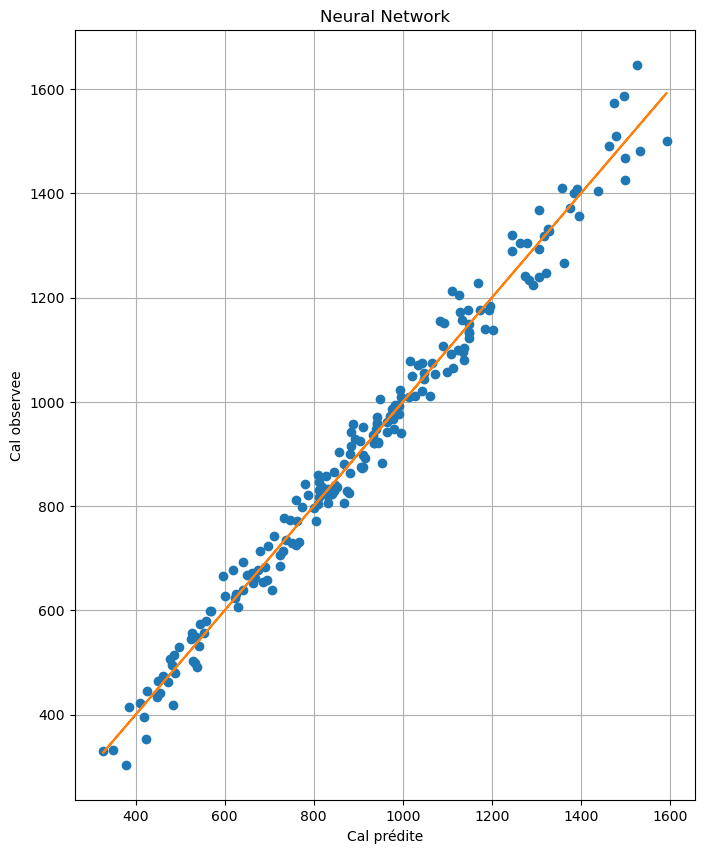

In [ ]:
plt.plot(pred_NN,YC_test,"o")
plt.plot(pred_NN,pred_NN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Neural Network")
plt.grid(True)
plt.show()

### Avec sélection de variables


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Meilleur score = 0.992333
Meilleur paramètre = {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
MSE sur test = 357.7763
R2= 0.9957976544643249


c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


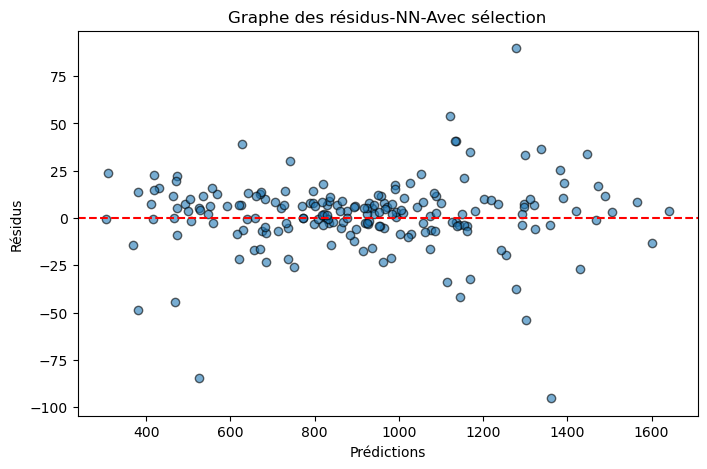

In [ ]:
#Système de paramètres pour l'optimisation
mlp = MLPRegressor(max_iter=500, random_state=42) 

grid_search_sel = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)#validation croisée pour trouver les paramètres opti
grid_search_sel.fit(XC_train_sel, YC_train)

print("Meilleur score = %f" % (grid_search_sel.best_score_)) # score moyen obtenu en validation croisée 
print("Meilleur paramètre =", grid_search_sel.best_params_)

# Évaluation sur test
best_model_sel = grid_search_sel.best_estimator_
pred_NN_sel = best_model_sel.predict(XC_test_sel)
mse_NN_sel = mean_squared_error(YC_test, pred_NN_sel )
print(f"MSE sur test = {mse_NN_sel:.4f}")
print("R2=",r2_score(YC_test,pred_NN_sel ))   # R2 sur l'échantillon test 

mse_score_model_sel["NN"]=mse_NN_sel 
R2_model_sel["NN"]=r2_score(YC_test,pred_NN_sel )
param_opt_models["NN"]=grid_search_sel.best_params_

residuals = YC_test - pred_NN_sel 
plt.figure(figsize=(8,5))
plt.scatter(pred_NN_sel , residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.title("Graphe des résidus-NN-Avec sélection")
plt.show()



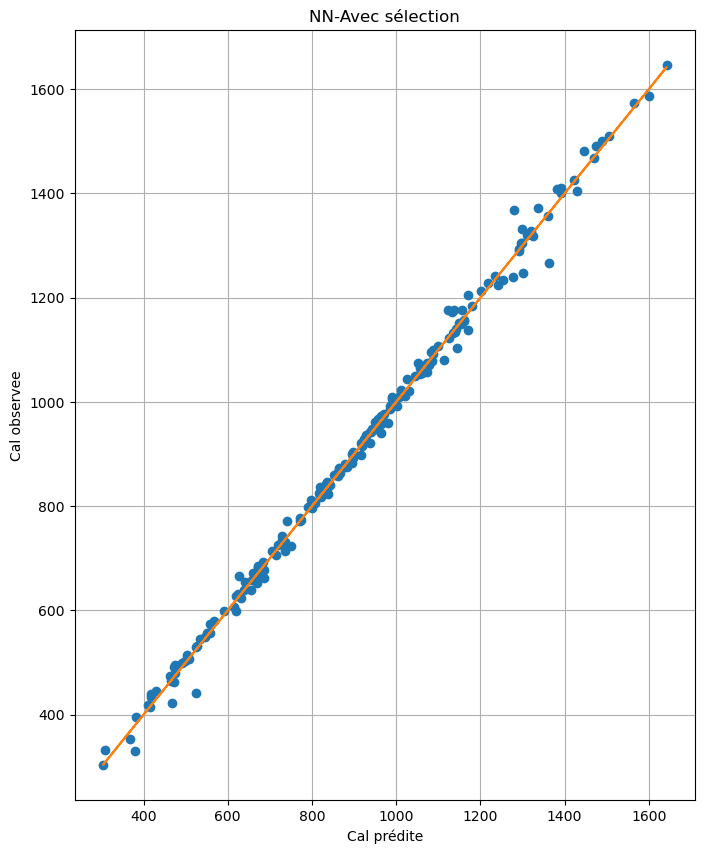

In [ ]:
plt.plot(pred_NN_sel,YC_test,"o")
plt.plot(pred_NN_sel,pred_NN_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("NN-Avec sélection")
plt.grid(True)
plt.show()

# 6. Deep-learning et réseaux profonds 
On va maintenant mettre en place un réseau profond avec la bibliothèque *tensorflow*. On rappelle les hyperparamètres qui sont optimissables pour ce type de modèles : 

| Hyperparamètre          | Description                                            | Valeurs possibles courantes                                                 |
| ----------------------- | ------------------------------------------------------ | --------------------------------------------------------------------------- |
| **n\_hidden**           | Nombre de couches cachées                              | 1, 2, 3, 4, 5                                                               |
| **n\_neurons**          | Nombre de neurones par couche cachée                   | 16, 32, 64, 128, 256                                                        |
| **activation**          | Fonction d’activation dans les couches cachées         | `'relu'`, `'tanh'`, `'sigmoid'`, `'elu'`                                    |
| **optimizer**           | Algorithme d’optimisation                              | `'adam'`, `'sgd'`, `'rmsprop'`, `'adagrad'`, `'adamax'`                     |
| **learning\_rate**      | Taux d’apprentissage                                   | 0.001, 0.01, 0.1, 0.0001                                                    |
| **batch\_size**         | Nombre d’exemples par batch lors de l’entraînement     | 16, 32, 64, 128                                                             |
| **epochs**              | Nombre d’itérations complètes sur le dataset           | 10, 20, 50, 100                                                             |
| **dropout\_rate**       | Fraction de neurones "éteints" lors du dropout         | 0.0 (pas de dropout), 0.1, 0.2, 0.3                                         |
| **weight\_initializer** | Méthode d'initialisation des poids                     | `'glorot_uniform'`, `'he_normal'`, `'random_normal'`                        |
| **loss\_function**      | Fonction de perte                                      | `'mse'` (régression), `'binary_crossentropy'`, `'categorical_crossentropy'` |
| **early\_stopping**     | Arrêt anticipé pour éviter surapprentissage (callback) | patience=5, monitor='val\_loss'                                             |
| **momentum**            | Pour optimizers SGD (optionnel)                        | 0.0, 0.9                                                                    |
| **regularization**      | Pénalisation L1, L2 pour éviter le surapprentissage    | lambda: 0.001, 0.01                                                         |


In [ ]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

# Définir la fonction de création du réseau
def build_model(n_hidden=1, n_neurons=32, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, input_shape=(XC_train.shape[1],), activation='relu')) #couche d'entrée
    for _ in range(n_hidden - 1): #nombre des couches cachés
        model.add(Dense(n_neurons, activation='relu')) #couche dense avec fonction activation relu 
    model.add(Dense(1))  # Régression : couche de sortie (1 sortie)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse') # fonction perte MSE
    return model

# Utilisation de scikeras
model = KerasRegressor(
    model=build_model,
    n_hidden=1,
    n_neurons=32,
    learning_rate=0.01,
    epochs=100,
    batch_size=32,
    verbose=0
)

# Grille des hyperparamètres
param_grid = {
    'n_hidden': [1, 2],
    'n_neurons': [16, 32, 64],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100 ]
}

# Grid search 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1)
grid_result = grid.fit(XC_train, YC_train)


Meilleur score (val. MSE) = 0.9804
Meilleurs paramètres : {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'n_hidden': 2, 'n_neurons': 32}
MSE sur test = 1258.9736
R2= 0.9852124304508746


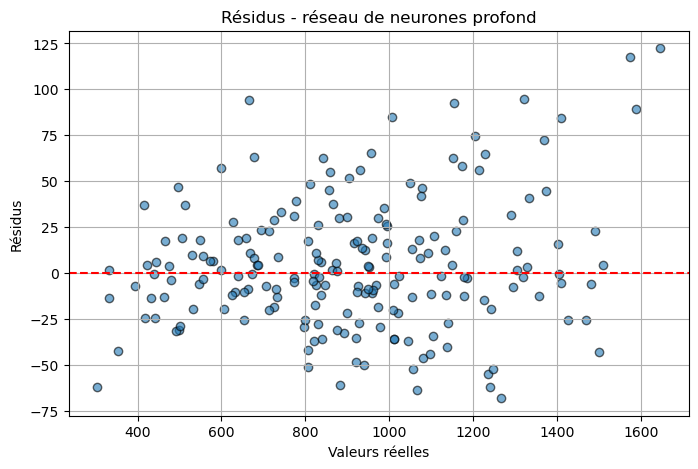

In [ ]:
# Résultat optimal
print("Meilleur score (val. MSE) = %.4f" % abs(grid_result.best_score_))  # convention MSE négative en sortie de la cross-validation
print("Meilleurs paramètres :", grid_result.best_params_)

# Prédiction avec le meilleur modèle
best_model = grid_result.best_estimator_
pred_DNN = best_model.predict(XC_test)

# Calcul des résidus et du MSE
residuals_DNN = YC_test - pred_DNN
mse_DNN = mean_squared_error(YC_test, pred_DNN)
print("MSE sur test = %.4f" % mse_DNN)
print("R2=",r2_score(YC_test,pred_DNN))   # R2 sur l'échantillon test 

mse_score_model["DNN"]=mse_DNN
R2_model["DNN"]=r2_score(YC_test,pred_DNN)

# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(YC_test, residuals_DNN, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.title("Résidus - réseau de neurones profond")
plt.grid(True)
plt.show()

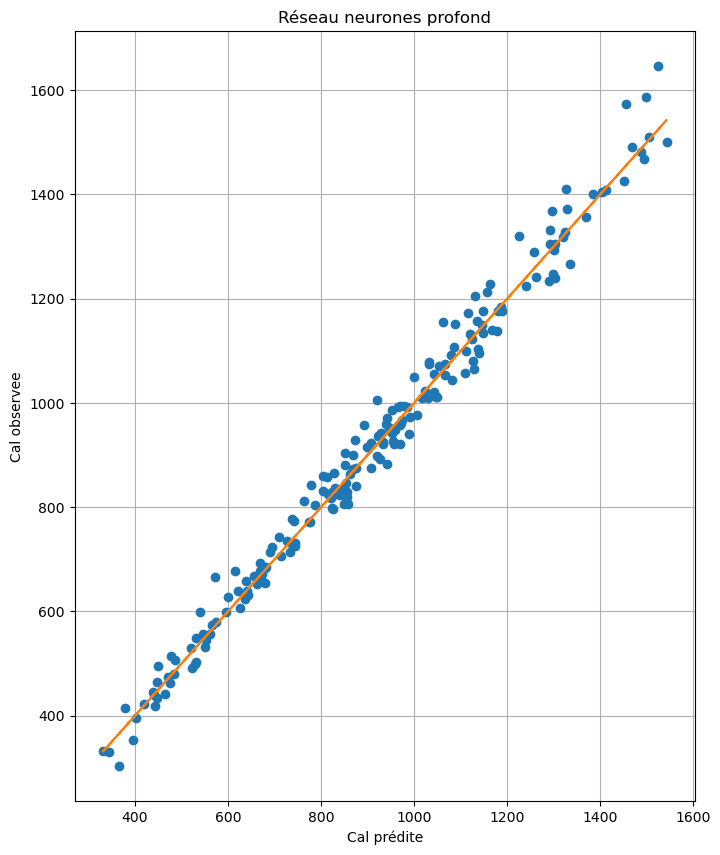

In [ ]:
plt.plot(pred_DNN,YC_test,"o")
plt.plot(pred_DNN,pred_DNN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Réseau neurones profond")
plt.grid(True)
plt.show()

### Avec sélection de variables

In [ ]:
def build_model_sel(n_hidden=1, n_neurons=32, learning_rate=0.01):
    input_dim = XC_train_sel.shape[1]  # taille adaptée
    model = Sequential()
    model.add(Dense(n_neurons, input_shape=(input_dim,), activation='relu'))
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

model_sel = KerasRegressor(
    build_model_sel,
    n_hidden=1,
    n_neurons=32,
    learning_rate=0.01,
    epochs=100,
    batch_size=32,
    verbose=0
)

param_grid_sel = {
    'n_hidden': [1, 2],
    'n_neurons': [16, 32, 64],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid_sel = GridSearchCV(model_sel, param_grid=param_grid_sel, cv=3, n_jobs=1)
grid_result_sel = grid_sel.fit(XC_train_sel, YC_train)

Meilleur score (val. MSE) = 0.9829
Meilleurs paramètres : {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'n_hidden': 1, 'n_neurons': 64}
MSE sur test = 913.5981
R2= 0.9892691191130686


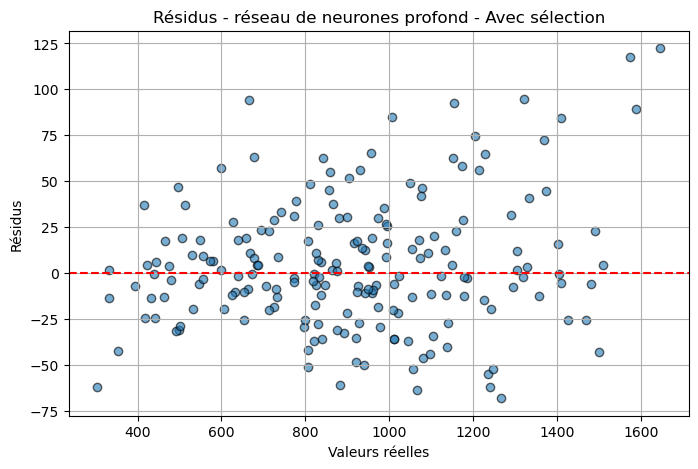

In [ ]:
# Résultat optimal
print("Meilleur score (val. MSE) = %.4f" % abs(grid_result_sel.best_score_))  # convention MSE négative en sortie de la cross-validation
print("Meilleurs paramètres :", grid_result_sel.best_params_)

# Prédiction avec le meilleur modèle
best_model_sel = grid_result_sel.best_estimator_
pred_DNN_sel = best_model_sel.predict(XC_test_sel)

# Calcul des résidus et du MSE
residuals_DNN_sel = YC_test - pred_DNN_sel
mse_DNN_sel = mean_squared_error(YC_test, pred_DNN_sel)
print("MSE sur test = %.4f" % mse_DNN_sel)
print("R2=",r2_score(YC_test,pred_DNN_sel))   # R2 sur l'échantillon test 

mse_score_model_sel["DNN"]=mse_DNN_sel
R2_model_sel["DNN"]=r2_score(YC_test,pred_DNN_sel)
param_opt_models["NN"]=grid_result_sel.best_params_
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(YC_test, residuals_DNN, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.title("Résidus - réseau de neurones profond - Avec sélection")
plt.grid(True)
plt.show()

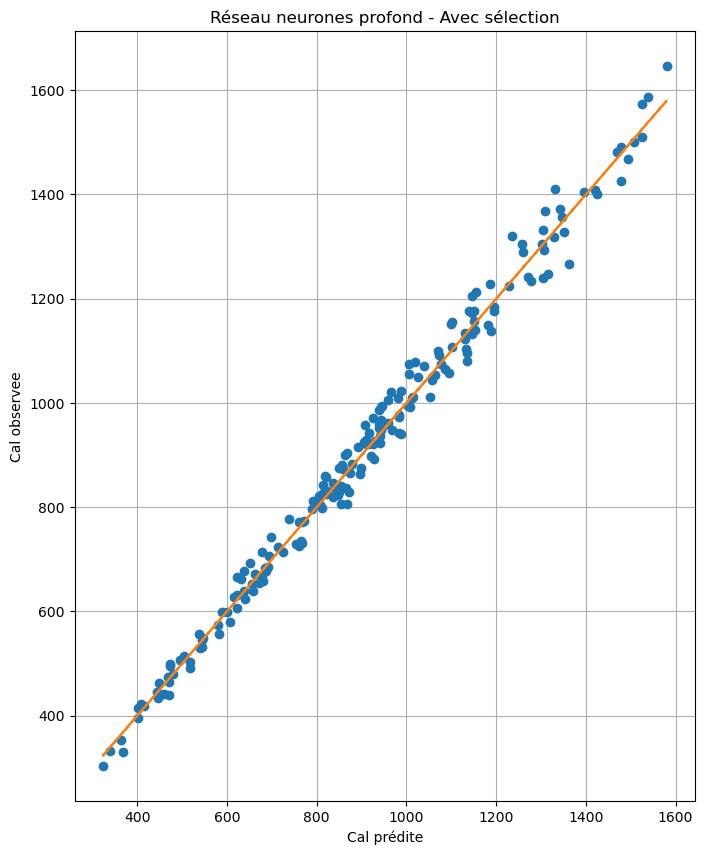

In [ ]:
plt.plot(pred_DNN_sel,YC_test,"o")
plt.plot(pred_DNN_sel,pred_DNN_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.title("Réseau neurones profond - Avec sélection")
plt.grid(True)
plt.show()

### Bilan réseaux de neurones : 

Les réseaux de neurones permettents d'obtenirs des performances de prédictions très impressionantes et au dessus des méthodes usuelles (hormis le boosting). On remarquera notamment les résidus qui sont très peu dispersés et bien compris autour d'un tube autour des [-100,100].

L'utilisation de deux librairies offrent une comparaison intéressante, en effet, *tensorflow* est une grosse librairi très bien adaptée et très utilisé dans les milieux industriels. Tandis que *sklearn.MLPRegressor* est plus simple et présente uniquement un type de couches (Dense). On a résumé quelques points caractéristiques entre les deux librairies : 

| Fonctionnalité            | MLPRegressor                      | TensorFlow/Keras                   |
| ------------------------- | --------------------------------- | ---------------------------------- |
| Nombre de couches cachées | Fixe (max 1 ou 2-3 hidden layers) | Illimité, tu définis la profondeur |
| Type de couches           | Dense uniquement                  | Dense, Conv, Recurrent, Custom...  |
| Activation                | Limitée (relu, tanh, logistic)    | Large choix + création perso       |
| Optimisation              | SGD, Adam (limité)                | Tous les optimizers modernes       |
| Support GPU               | Non                               | Oui (accélération matérielle)      |

On voit ici que une *MLPRegressor* suffit amplement et propose même, avec nos choix de paramètres, des performances plus élevées que *tensorflow*. Sans nulle doute qu'on pourrait encore améliorer les performances du réseaux profonds en utilisant plus de couches par exemple ou en prenant des couches différentes via *tensorflow*.

Mais au vu du temps d'éxécution déjà élevé du code actuel, on se contentera de ces performances. 



### Comparaison des performances des méthodes : 
 
On va maintenant tracer tout les MSE obtenus pour chacun des modèles grâce à au dictionnaire *mse_score_model*. 


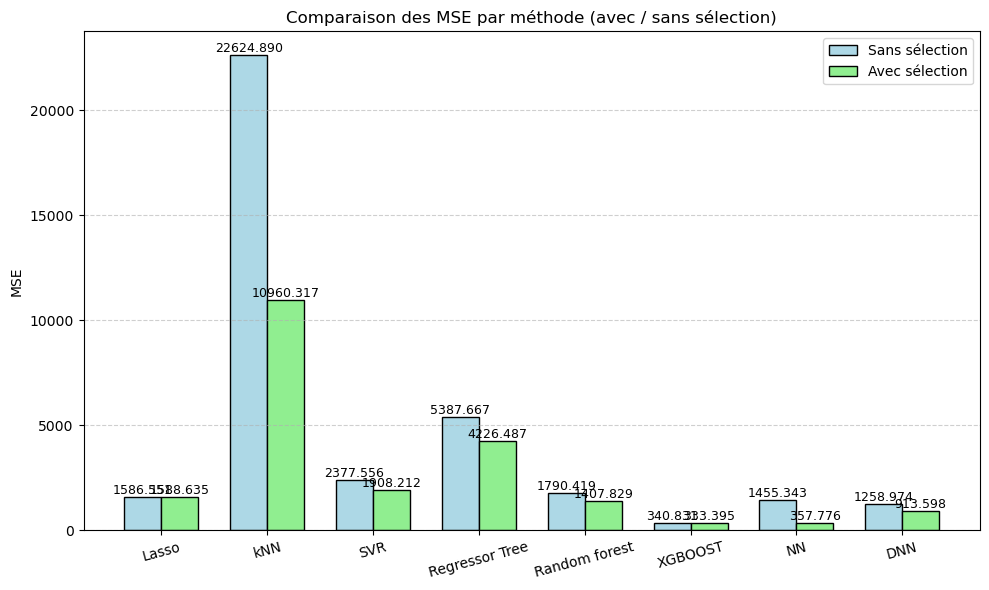

In [ ]:
# Même ordre pour les 2 dictionnaires
methods = list(mse_score_model.keys())
methods.remove('Linear Regression') #on supprime modèle linéaire simple 

mse_base = [mse_score_model[method] for method in methods]
mse_sel = [mse_score_model_sel[method] for method in methods]

# Largeur et positions
x = np.arange(len(methods))
width = 0.35

# Tracé
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mse_base, width, label='Sans sélection', color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, mse_sel, width, label='Avec sélection', color='lightgreen', edgecolor='black')

# Mise en forme
ax.set_ylabel('MSE')
ax.set_title("Comparaison des MSE par méthode (avec / sans sélection)")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Annotations
for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Cross-validation pour Lasso
Lasso: MSE moyen = 1618.3893, std = 89.8026
Cross-validation pour kNN
kNN: MSE moyen = 25160.2351, std = 1726.2509
Cross-validation pour SVR
SVR: MSE moyen = 3541.5981, std = 935.2216
Cross-validation pour Decision Tree
Decision Tree: MSE moyen = 6193.8271, std = 1161.6123
Cross-validation pour Random Forest
Random Forest: MSE moyen = 3671.5580, std = 415.8019
Cross-validation pour XGBOOST
XGBOOST: MSE moyen = 511.0277, std = 116.3246
Cross-validation pour NN
NN: MSE moyen = 1279.9683, std = 61.9630


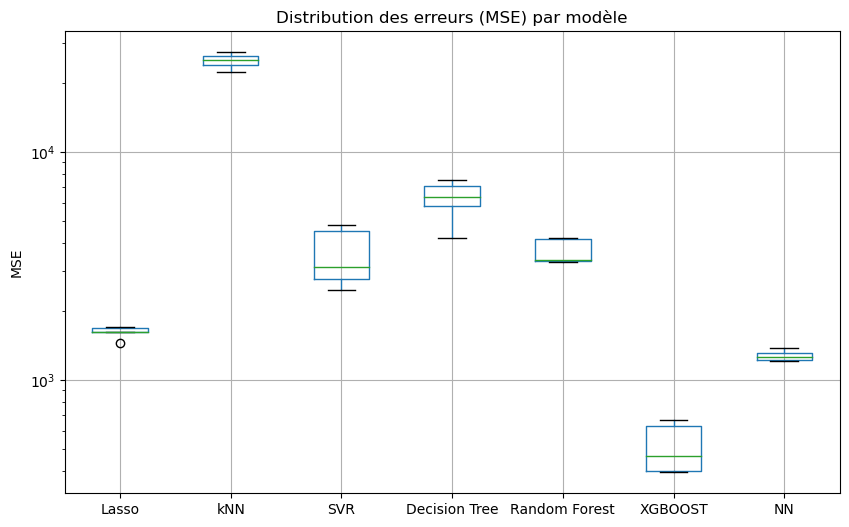

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
# Paramètres optimaux
# Fonction de construction du réseau Keras
def build_nn_model(n_hidden=1, n_neurons=64, learning_rate=0.01, input_dim=None):
    model = Sequential()
    model.add(Dense(n_neurons, input_shape=(input_dim,), activation='relu'))
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

best_params=param_opt_models

# Construction des modèles optimisés
models = {
    "Lasso": Lasso(alpha=best_params['Lasso']),
    "kNN": KNeighborsRegressor(**best_params['kNN']),
    "SVR": SVR(**best_params['SVR']),
    "Decision Tree": DecisionTreeRegressor(**best_params['Regressor Tree']),
    "Random Forest": RandomForestRegressor(max_features=best_params['Random forest']['max_features']),
    "XGBOOST": xgb.XGBRegressor(
        learning_rate=best_params['XGBOOST']['learning_rate'],
        max_depth=best_params['XGBOOST']['max_depth'],
        n_estimators=best_params['XGBOOST']['n_estimators'],
        use_label_encoder=False,
        eval_metric='rmse'
    ),
    "NN": KerasRegressor(
        build_fn=lambda: build_nn_model(
            n_hidden=best_params['NN']['n_hidden'],
            n_neurons=best_params['NN']['n_neurons'],
            learning_rate=best_params['NN']['learning_rate'],
            input_dim=XC_train.shape[1]
        ),
        epochs=best_params['NN']['epochs'],
        batch_size=best_params['NN']['batch_size'],
        verbose=0
    )
}

# Définir le scorer MSE (négatif car cross_val_score maximise)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

mse_means = []
mse_stds = []
model_names = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Dictionnaire pour stocker les listes de MSE par modèle
scores_dict = {name: [] for name in models.keys()}
for name, model in models.items():
    print(f"Cross-validation pour {name}")
    scores = cross_val_score(model, XC_train, YC_train, cv=cv, scoring=mse_scorer, n_jobs=-1)
    scores = -scores  # pour avoir la MSE positive
    mse_means.append(np.mean(scores))
    mse_stds.append(np.std(scores))
    model_names.append(name)
    print(f"{name}: MSE moyen = {np.mean(scores):.4f}, std = {np.std(scores):.4f}")
    scores_dict[name] = scores
    
# Création du DataFrame avec les résultats CV
dataframeErreur = pd.DataFrame(scores_dict)

plt.figure(figsize=(10, 6))
dataframeErreur[list(models.keys())].boxplot(return_type='dict')
plt.yscale('log')  # Ajout d'une échelle logarithmique pour la visibilité 
plt.title("Distribution des erreurs (MSE) par modèle")
plt.ylabel("MSE")
plt.show()

### Bilan : (régression)

| Modèle        | Performance (MSE moyen)  | Stabilité (Variance) | Commentaire principal                                           |
| ------------- | ------------------------ | -------------------- | --------------------------------------------------------------- |
| XGBOOST       | Très faible (\~400–1200) | Moyenne              | Meilleur modèle, très performant et acceptablement stable.      |
| NN            | Faible (\~1200–1500)     | Bonne                | Bon modèle, bonne généralisation.                               |
| Lasso         | Faible (\~1400–1700)     | Excellente           | Très stable, performant mais légèrement inférieur à NN/XGBOOST. |
| Random Forest | Moyen (\~4000–5000)      | Bonne                | Robuste mais moins précis que XGBOOST ou NN.                    |
| Decision Tree | Moyen (\~6000–8000)      | Moyenne              | Simple, moins efficace seul.                                    |
| SVR           | Variable (\~2500–6000)   | Forte                | Performance variable selon les folds.                           |
| kNN           | Très élevé (\~20 000)    | Très stable          | Très mauvaise précision (par rapport aux autres) malgré faible variance.                 |


# 2.2 Prédiction du niveau d'expérience (classification)

# 2.2.1 Régression multinomiale

On prépare les données d'une autre manière pour la classification

In [ ]:
# chargement  données
df = pd.read_csv("gym_members_exercise_tracking.csv")

# aperçu 
print(df.head())

# résumé statistique 
print(df.describe(include='all').transpose())


# on convertit les colonnes qualitatives
categorical_cols = [
    'Gender',
    'Workout_Type',
    'Experience_Level',
    'Workout_Frequency (days/week)'
]
for col in categorical_cols:
    df[col] = df[col].astype('category')



df_norm = df.copy()
df_norm['sBMI'] = np.sqrt(df_norm['BMI'])
df_norm['sWeight (kg)'] = np.sqrt(df_norm['Weight (kg)'])
df_norm['sCalories_Burned'] = np.sqrt(df_norm['Calories_Burned'])

lambda_ = 2
df_norm['BCFat_Percentage'] = (df_norm['Fat_Percentage'] ** lambda_) / lambda_


   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM   
0   56    Male         88.3        1.71      180      157           60  \
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage   
0                      1.69           1313.0         Yoga            12.6  \
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level   
0              

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

f1_dico_comp={}

# Fonction : Taux d'erreur à partir d'une matrice de confusion
def erreur_pourcentage(conf_matrix):
    total = np.sum(conf_matrix)
    correct = np.trace(conf_matrix)
    erreurs = total - correct
    pourcentage = (erreurs / total) * 100
    print(f"Pourcentage d'erreur : {pourcentage:.2f} %")
    return pourcentage



# Fonction : Matrice de confusion 

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Matrice de confusion"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    return cm



# Fonction : ROC par classe 
def plot_roc_curves(y_true, y_probs, class_names, model_name="Modèle"):
    y_bin = label_binarize(y_true, classes=class_names)
    
    plt.figure(figsize=(8, 6))
    colors = plt.cm.Set2(np.linspace(0, 1, len(class_names)))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{class_name} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC par classe — {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Fonction : Superposition de courbes ROC 
def plot_superposed_roc_curves(y_true, probs_1, name_1, probs_2, name_2, class_names):
    y_bin = label_binarize(y_true, classes=class_names)
    
    plt.figure(figsize=(10, 8))
    colors1 = plt.cm.Set2(np.linspace(0, 1, len(class_names)))
    colors2 = plt.cm.Dark2(np.linspace(0, 1, len(class_names)))
    
    for i, class_name in enumerate(class_names):
        fpr1, tpr1, _ = roc_curve(y_bin[:, i], probs_1[:, i])
        fpr2, tpr2, _ = roc_curve(y_bin[:, i], probs_2[:, i])
        plt.plot(fpr1, tpr1, color=colors1[i], lw=2, linestyle='-', label=f"{name_1} — {class_name}")
        plt.plot(fpr2, tpr2, color=colors2[i], lw=2, linestyle='--', label=f"{name_2} — {class_name}")
    
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbes ROC superposées : {name_1} vs {name_2}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# séparation variables quanti et quali
quanti_columns = [
    'Age', 'sWeight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
    'Resting_BPM', 'Session_Duration (hours)', 'sCalories_Burned',
    'BCFat_Percentage', 'Water_Intake (liters)', 'sBMI'
]

quali_columns = [
    'Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level'
]
# Colonnes numériques à standardiser
quanti_columns_bis_norm = quanti_columns.copy()

# Colonnes qualitatives à encoder, on exclut notre variable cible
categorical_cols = ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)']

# Séparation des features et de la cible
X = df_norm.drop(columns=["Experience_Level"])
y = df_norm["Experience_Level"]

# Split train/test stratifié
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1234
)

# Reconstruction des DataFrames complets pour inspection ou visualisation
data_exp_norm = X_train_raw.copy()
data_exp_norm["Experience_Level"] = y_train

data_test_norm = X_test_raw.copy()
data_test_norm["Experience_Level"] = y_test

# Standardisation des variables numériques
scaler = StandardScaler()
data_exp_norm[quanti_columns_bis_norm] = scaler.fit_transform(data_exp_norm[quanti_columns_bis_norm])
data_test_norm[quanti_columns_bis_norm] = scaler.transform(data_test_norm[quanti_columns_bis_norm])

# Encodage one-hot 
X_train_encoded = pd.get_dummies(
    data_exp_norm.drop(columns=["Experience_Level"]),
    columns=categorical_cols,
    drop_first=True
)
X_test_encoded = pd.get_dummies(
    data_test_norm.drop(columns=["Experience_Level"]),
    columns=categorical_cols,
    drop_first=True
)

# Harmonisation des colonnes entre train et test
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

Coefficients :
        Age  Weight (kg)  Height (m)   Max_BPM   Avg_BPM  Resting_BPM   
1 -0.739851     0.206553   -0.176054 -0.149772  2.023702     0.386255  \
2 -0.749045     0.100819    0.763721 -0.083813  1.807645     0.464032   
3  1.488897    -0.307372   -0.587667  0.233585 -3.831347    -0.850286   

   Session_Duration (hours)  Calories_Burned  Fat_Percentage   
1                 -1.264958        -0.014826        1.026781  \
2                 -0.550304        -0.019566        0.939114   
3                  1.815262         0.034392       -1.965894   

   Water_Intake (liters)  ...  sWeight (kg)  sCalories_Burned   
1               0.159070  ...      0.207505         -0.770235  \
2              -0.121864  ...      0.722287          1.588042   
3              -0.037207  ...     -0.929792         -0.817807   

   BCFat_Percentage  Gender_Male  Workout_Type_HIIT  Workout_Type_Strength   
1          0.364354     0.567963          -0.210248              -0.048493  \
2          0.97476

c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


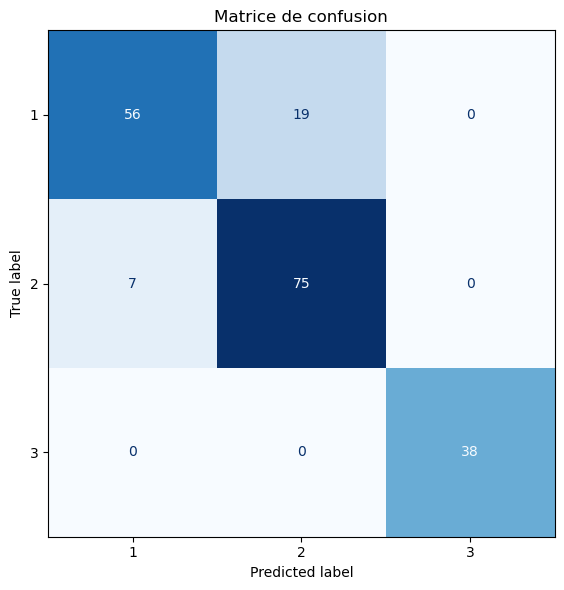

Pourcentage d'erreur : 13.33 %
              precision    recall  f1-score   support

           1       0.89      0.75      0.81        75
           2       0.80      0.91      0.85        82
           3       1.00      1.00      1.00        38

    accuracy                           0.87       195
   macro avg       0.90      0.89      0.89       195
weighted avg       0.87      0.87      0.87       195

F1-score macro : 0.8880


In [ ]:
# Régression multinomiale sans pénalisation
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    C=1e10,  
    max_iter=1000,
    random_state=42
)

model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)

# Coefficients par classe
coef_df = pd.DataFrame(model.coef_, columns=X_train_encoded.columns)
coef_df.index = model.classes_
print("Coefficients :")
print(coef_df)

# Matrice de confusion
conf_matrix = plot_confusion_matrix(y_test, y_pred, labels=model.classes_)
erreur_pourcentage(conf_matrix)

# Rapport de classification
print(classification_report(y_test, y_pred))
report_multi = classification_report(y_test, y_pred, output_dict=True)
f1_macro_multi = report_multi['macro avg']['f1-score']
f1_dico_comp["Multi reg"]=f1_macro_multi
print(f"F1-score macro : {f1_macro_multi:.4f}")

# Ridge 

In [ ]:
# Sélection du lambda optimal par validation croisée 
ridge_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 2, 200),
    cv=cv,
    penalty="l2",
    solver="saga",
    multi_class="multinomial",
    scoring="neg_log_loss",
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)
ridge_cv.fit(X_train_encoded, y_train) 

# Analyse des scores de validation croisée 
true_Cs = ridge_cv.Cs_
true_lambdas = 1 / np.array(true_Cs)

logloss_all = np.array([
    -ridge_cv.scores_[cls].mean(axis=0) for cls in ridge_cv.scores_.keys()
])
mean_logloss = logloss_all.mean(axis=0)
std_logloss = logloss_all.std(axis=0)

best_index = mean_logloss.argmin()
best_lambda_ridge = true_lambdas[best_index]


print(f"[Ridge] Best lambda : {best_lambda_ridge:.6f}")

[Ridge] Best lambda : 0.010000



Coefficients pour la classe 1:
Age                               -0.024660
Weight (kg)                        0.034416
Height (m)                         0.007758
Max_BPM                           -0.002214
Avg_BPM                            0.092034
Resting_BPM                        0.006393
Session_Duration (hours)          -0.096589
Calories_Burned                   -0.006401
Fat_Percentage                     0.222271
Water_Intake (liters)              0.033546
BMI                               -0.035957
sBMI                              -0.058081
sWeight (kg)                      -0.048558
sCalories_Burned                  -0.059820
BCFat_Percentage                  -0.026638
Gender_Male                        0.030210
Workout_Type_HIIT                  0.009457
Workout_Type_Strength              0.005271
Workout_Type_Yoga                 -0.008991
Workout_Frequency (days/week)_3    0.012555
Workout_Frequency (days/week)_4   -0.186188
Workout_Frequency (days/week)_5   -0.003585


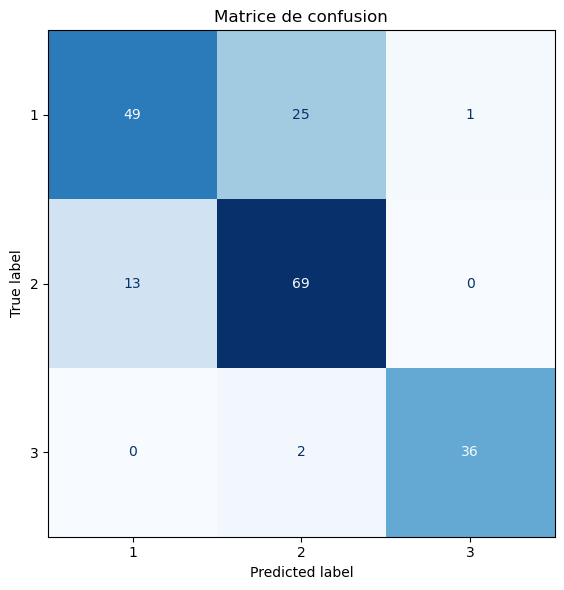

Pourcentage d'erreur : 21.03 %
Rapport de classification :
              precision    recall  f1-score   support

           1       0.79      0.65      0.72        75
           2       0.72      0.84      0.78        82
           3       0.97      0.95      0.96        38

    accuracy                           0.79       195
   macro avg       0.83      0.81      0.82       195
weighted avg       0.80      0.79      0.79       195

F1-score macro : 0.8169


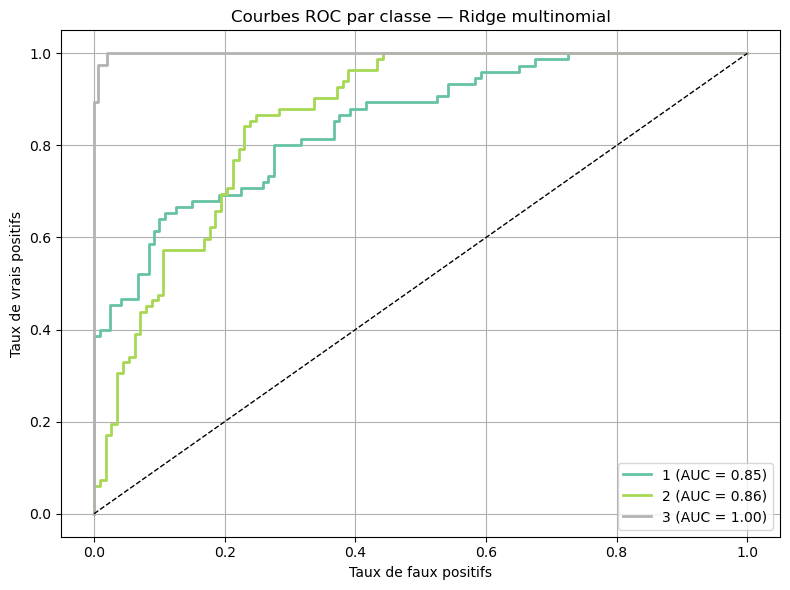

In [ ]:
# Entraînement du modèle le meilleur lambda trouvé par CV
ridge_model = LogisticRegression(
    C=1 / best_lambda_ridge, 
    penalty='l2',
    solver='saga',
    multi_class='multinomial',
    max_iter=5000,
    random_state=42
)
ridge_model.fit(X_train_encoded, y_train)

# Prédictions
y_pred_ridge = ridge_model.predict(X_test_encoded)
y_proba_ridge = ridge_model.predict_proba(X_test_encoded)

# Coefficients par classe
for i, class_label in enumerate(ridge_model.classes_):
    print(f"\nCoefficients pour la classe {class_label}:")
    print(pd.Series(ridge_model.coef_[i], index=X_train_encoded.columns))

print("\nIntercepts (biais) pour chaque classe :")
print(ridge_model.intercept_)

# Évaluation
conf_matrix_ridge = plot_confusion_matrix(y_test, y_pred_ridge, labels=ridge_model.classes_)
erreur_pourcentage(conf_matrix_ridge)

print("Rapport de classification :")
print(classification_report(y_test, y_pred_ridge))
report_ridge = classification_report(y_test, y_pred_ridge, output_dict=True)
f1_macro_ridge = report_ridge['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_ridge:.4f}")
f1_dico_comp["Ridge"]=f1_macro_ridge
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_ridge,
    class_names=ridge_model.classes_,
    model_name="Ridge multinomial"
)


# Lasso

[Lasso] Best lambda : 0.100000


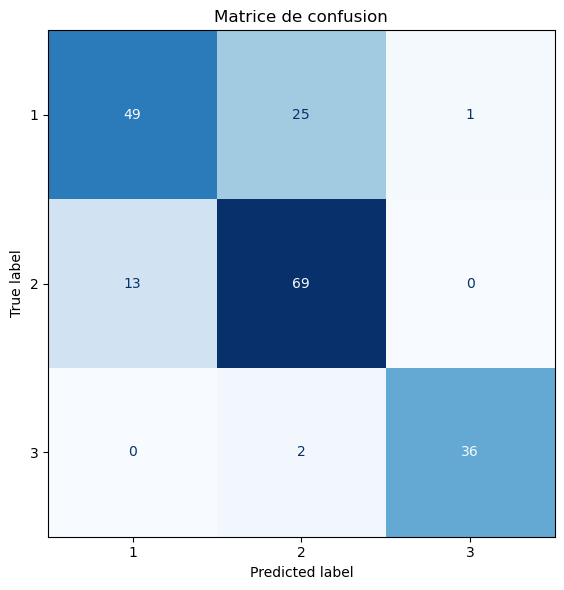

Pourcentage d'erreur : 21.03 %
Rapport Lasso :
              precision    recall  f1-score   support

           1       0.79      0.65      0.72        75
           2       0.72      0.84      0.78        82
           3       0.97      0.95      0.96        38

    accuracy                           0.79       195
   macro avg       0.83      0.81      0.82       195
weighted avg       0.80      0.79      0.79       195

F1-score macro : 0.8169


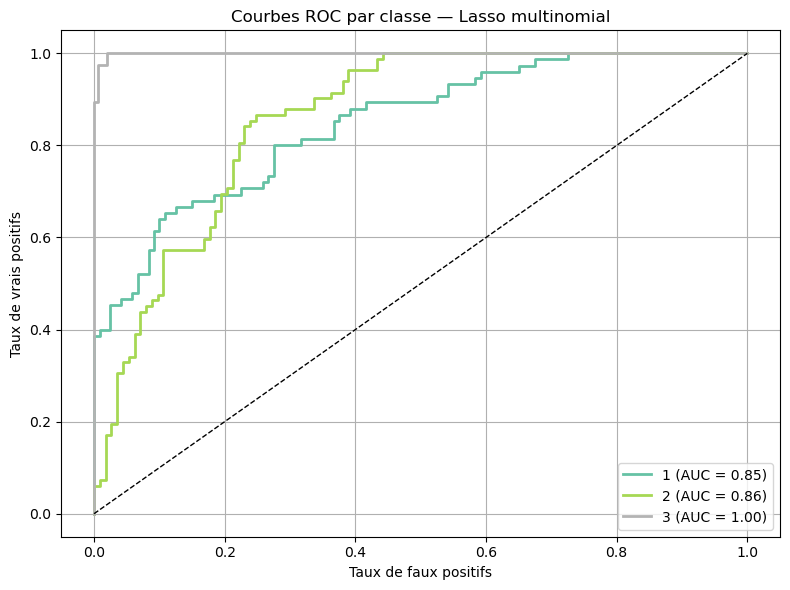

In [ ]:
# Sélection du lambda optimal par validation croisée
lasso_cv = LogisticRegressionCV(
    Cs=np.logspace(-2.5, 1, 100),
    cv=cv,
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    scoring='neg_log_loss',
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)
lasso_cv.fit(X_train_encoded, y_train)

#  Analyse des scores de validation croisée 
true_Cs = lasso_cv.Cs_
true_lambdas = 1 / np.array(true_Cs)

logloss_all = np.array([
    -lasso_cv.scores_[cls].mean(axis=0) for cls in lasso_cv.scores_.keys()
])
mean_logloss = logloss_all.mean(axis=0)
std_logloss = logloss_all.std(axis=0)

best_index = mean_logloss.argmin()
best_lambda_lasso = true_lambdas[best_index]




print(f"[Lasso] Best lambda : {best_lambda_lasso:.6f}")

#  Entraînement avec le meilleur lambda 
lasso_model = LogisticRegression(
    C=1 / best_lambda_lasso,
    penalty='l1',
    solver='saga',
    multi_class='multinomial',
    max_iter=5000,
    random_state=42
)
lasso_model.fit(X_train_encoded, y_train)

# évaluation 
y_pred_lasso = lasso_model.predict(X_test_encoded)
y_proba_lasso = lasso_model.predict_proba(X_test_encoded)

conf_matrix_lasso = plot_confusion_matrix(y_test, y_pred_lasso, labels=lasso_model.classes_)
erreur_pourcentage(conf_matrix_lasso)

print("Rapport Lasso :")
print(classification_report(y_test, y_pred_lasso))
report_lasso = classification_report(y_test, y_pred_lasso, output_dict=True)
f1_macro_lasso = report_lasso['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_lasso:.4f}")
f1_dico_comp["Lasso"]=f1_macro_lasso
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_lasso,
    class_names=lasso_model.classes_,
    model_name="Lasso multinomial"
)





# 2.2.2 Classification par analyse discriminante

**LDA**

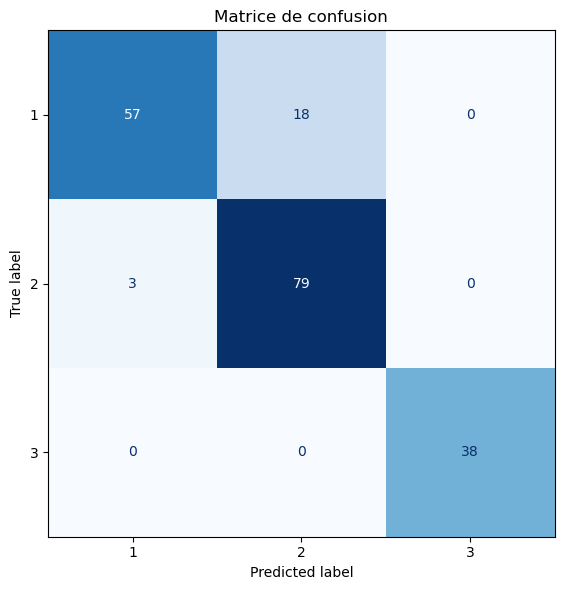

Pourcentage d'erreur : 10.77 %
Rapport LDA :
              precision    recall  f1-score   support

           1       0.95      0.76      0.84        75
           2       0.81      0.96      0.88        82
           3       1.00      1.00      1.00        38

    accuracy                           0.89       195
   macro avg       0.92      0.91      0.91       195
weighted avg       0.90      0.89      0.89       195

F1-score macro : 0.9090


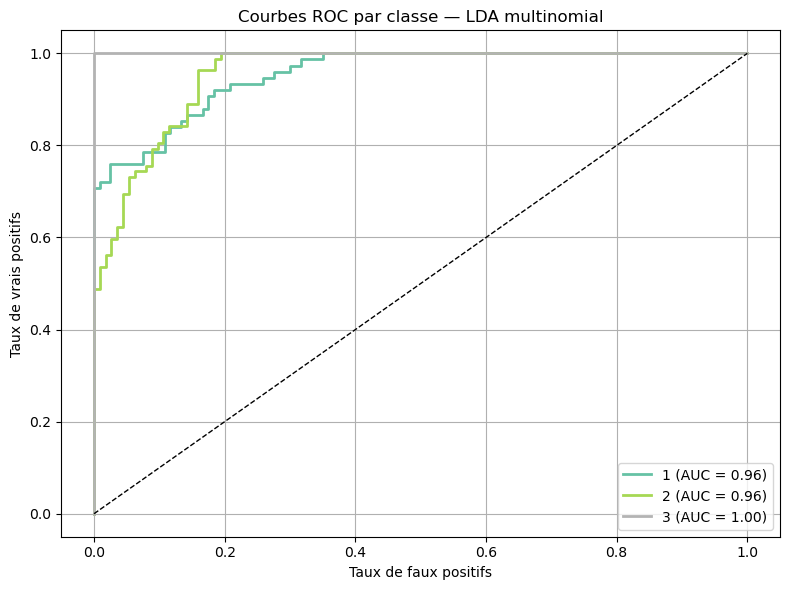

In [ ]:

#  LDA 
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_encoded, y_train)

# prédictions 
y_pred_lda = lda_model.predict(X_test_encoded)
y_proba_lda = lda_model.predict_proba(X_test_encoded)

# Évaluation
conf_matrix_lda = plot_confusion_matrix(y_test, y_pred_lda, labels=lda_model.classes_)
erreur_pourcentage(conf_matrix_lda)

print("Rapport LDA :")
print(classification_report(y_test, y_pred_lda))
report_lda = classification_report(y_test, y_pred_lda, output_dict=True)
f1_macro_lda = report_lda['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_lda:.4f}")
f1_dico_comp["LDA"]=f1_macro_lda
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_lda,
    class_names=lda_model.classes_,
    model_name="LDA multinomial"
)




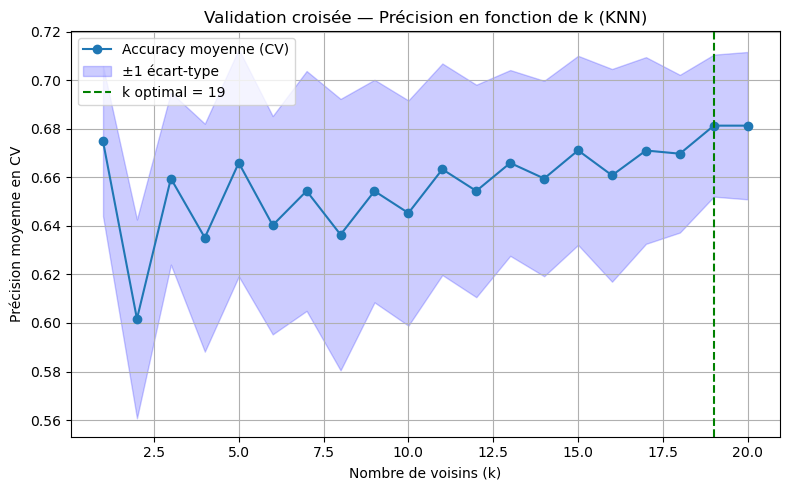

[KNN] Meilleur k (nombre de voisins) : 19


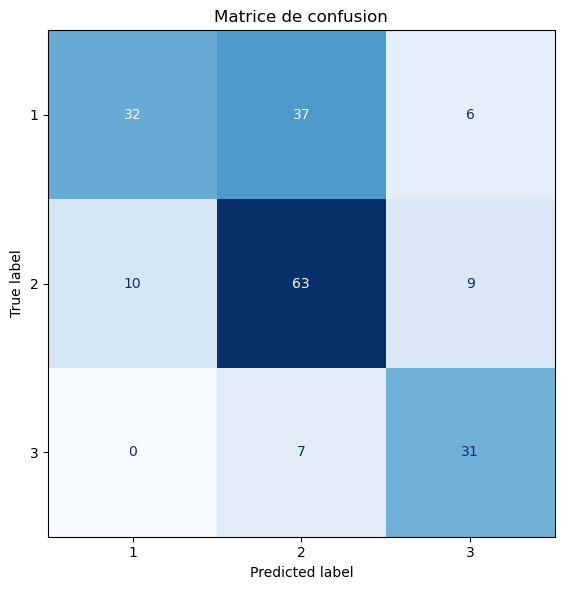

Pourcentage d'erreur : 35.38 %
Rapport KNN :
              precision    recall  f1-score   support

           1       0.76      0.43      0.55        75
           2       0.59      0.77      0.67        82
           3       0.67      0.82      0.74        38

    accuracy                           0.65       195
   macro avg       0.67      0.67      0.65       195
weighted avg       0.67      0.65      0.63       195

F1-score macro : 0.6506


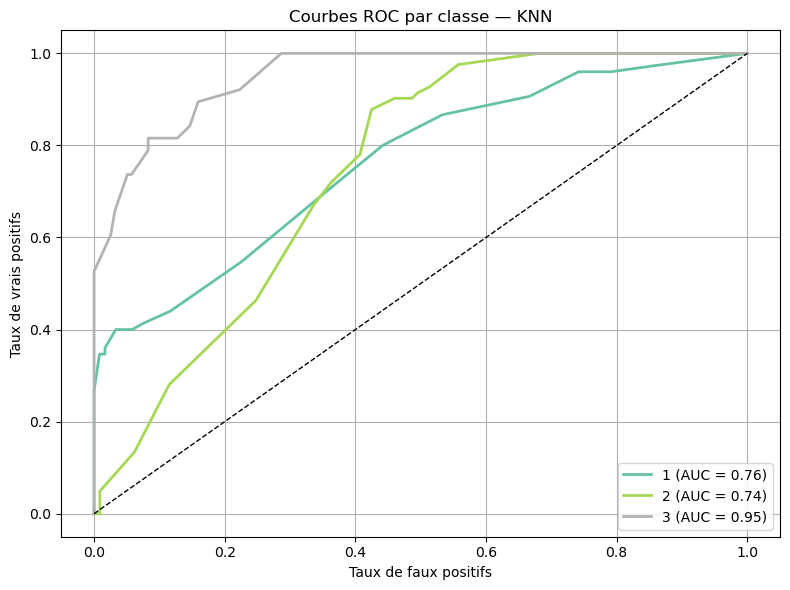

In [ ]:

# Grille de paramètres pour le nombre de voisins 
param_grid = {'n_neighbors': list(range(1, 21))}

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# entraînement avec cross-validation 
knn_grid.fit(X_train_encoded, y_train)

best_k = knn_grid.best_params_["n_neighbors"]

k_values = knn_grid.cv_results_['param_n_neighbors'].data.astype(int)
mean_scores = knn_grid.cv_results_['mean_test_score']
std_scores = knn_grid.cv_results_['std_test_score']


plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_scores, marker='o', label="Accuracy moyenne (CV)")
plt.fill_between(
    k_values,
    mean_scores - std_scores,
    mean_scores + std_scores,
    alpha=0.2,
    color='blue',
    label="±1 écart-type"
)
plt.axvline(best_k, color='green', linestyle='--', label=f"k optimal = {best_k}")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne en CV")
plt.title("Validation croisée — Précision en fonction de k (KNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"[KNN] Meilleur k (nombre de voisins) : {best_k}")

#entraînement final avec le meilleur k 
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_encoded, y_train)

y_pred_knn = knn_model.predict(X_test_encoded)
y_proba_knn = knn_model.predict_proba(X_test_encoded)

conf_matrix_knn = plot_confusion_matrix(y_test, y_pred_knn, labels=knn_model.classes_)
erreur_pourcentage(conf_matrix_knn)

print("Rapport KNN :")
print(classification_report(y_test, y_pred_knn))
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
f1_macro_knn = report_knn['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_knn:.4f}")
f1_dico_comp["kNN"]=f1_macro_knn

plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_knn,
    class_names=knn_model.classes_,
    model_name="KNN"
)



****SVM linéaire****

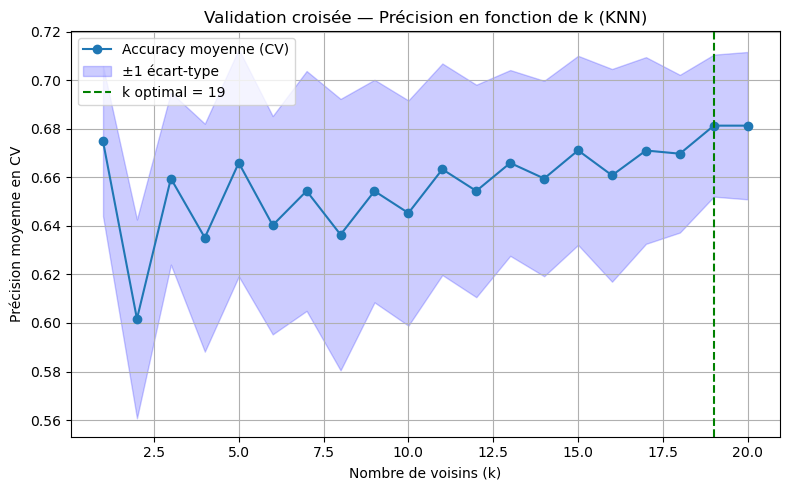

[KNN] Meilleur k (nombre de voisins) : 19


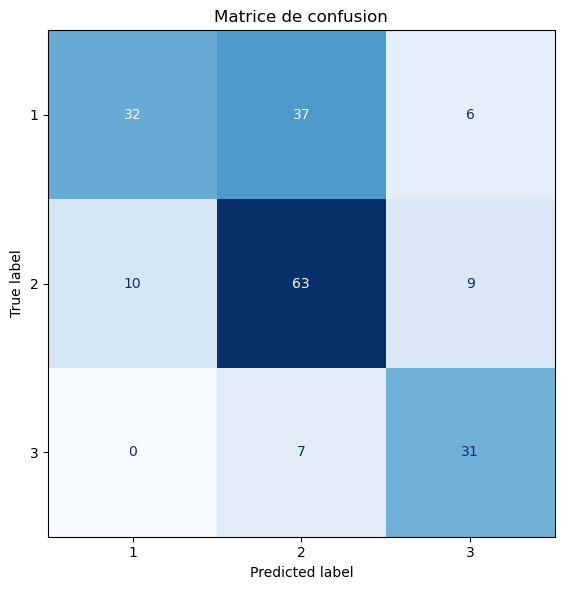

Pourcentage d'erreur : 35.38 %
Rapport KNN :
              precision    recall  f1-score   support

           1       0.76      0.43      0.55        75
           2       0.59      0.77      0.67        82
           3       0.67      0.82      0.74        38

    accuracy                           0.65       195
   macro avg       0.67      0.67      0.65       195
weighted avg       0.67      0.65      0.63       195

F1-score macro : 0.6506


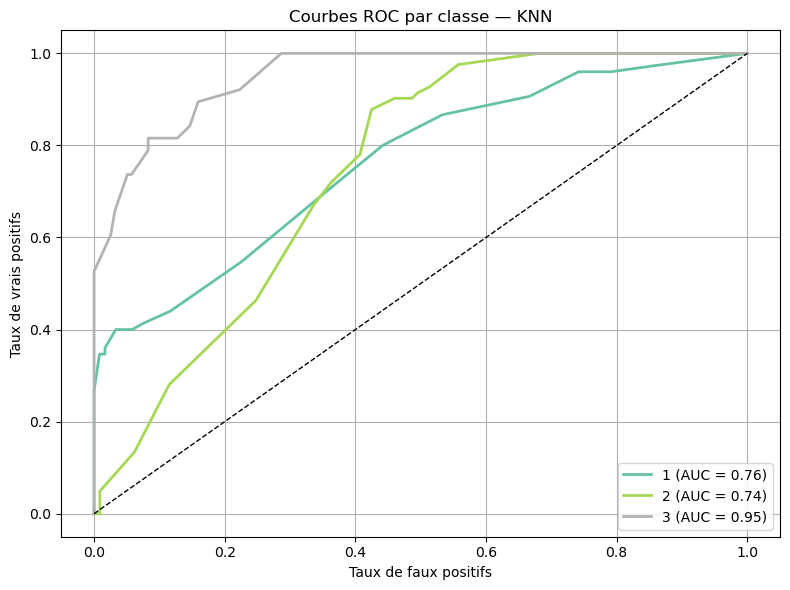

In [ ]:

# Grille de paramètres pour le nombre de voisins 
param_grid = {'n_neighbors': list(range(1, 21))}

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# entraînement avec cross-validation 
knn_grid.fit(X_train_encoded, y_train)

best_k = knn_grid.best_params_["n_neighbors"]

k_values = knn_grid.cv_results_['param_n_neighbors'].data.astype(int)
mean_scores = knn_grid.cv_results_['mean_test_score']
std_scores = knn_grid.cv_results_['std_test_score']


plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_scores, marker='o', label="Accuracy moyenne (CV)")
plt.fill_between(
    k_values,
    mean_scores - std_scores,
    mean_scores + std_scores,
    alpha=0.2,
    color='blue',
    label="±1 écart-type"
)
plt.axvline(best_k, color='green', linestyle='--', label=f"k optimal = {best_k}")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne en CV")
plt.title("Validation croisée — Précision en fonction de k (KNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"[KNN] Meilleur k (nombre de voisins) : {best_k}")

#entraînement final avec le meilleur k 
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_encoded, y_train)

y_pred_knn = knn_model.predict(X_test_encoded)
y_proba_knn = knn_model.predict_proba(X_test_encoded)

conf_matrix_knn = plot_confusion_matrix(y_test, y_pred_knn, labels=knn_model.classes_)
erreur_pourcentage(conf_matrix_knn)

print("Rapport KNN :")
print(classification_report(y_test, y_pred_knn))
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
f1_macro_knn = report_knn['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_knn:.4f}")
f1_dico_comp["kNN"]=f1_macro_knn

plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_knn,
    class_names=knn_model.classes_,
    model_name="KNN"
)



****SVM kernel radial****

[SVM RBF] Meilleur C : 100.0
[SVM RBF] Meilleur gamma : 0.0001


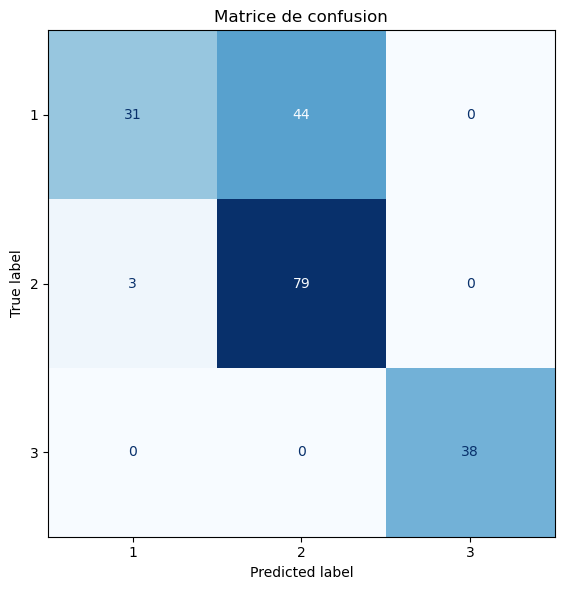

Pourcentage d'erreur : 24.10 %
Rapport SVM RBF :
              precision    recall  f1-score   support

           1       0.91      0.41      0.57        75
           2       0.64      0.96      0.77        82
           3       1.00      1.00      1.00        38

    accuracy                           0.76       195
   macro avg       0.85      0.79      0.78       195
weighted avg       0.82      0.76      0.74       195

F1-score macro : 0.7798


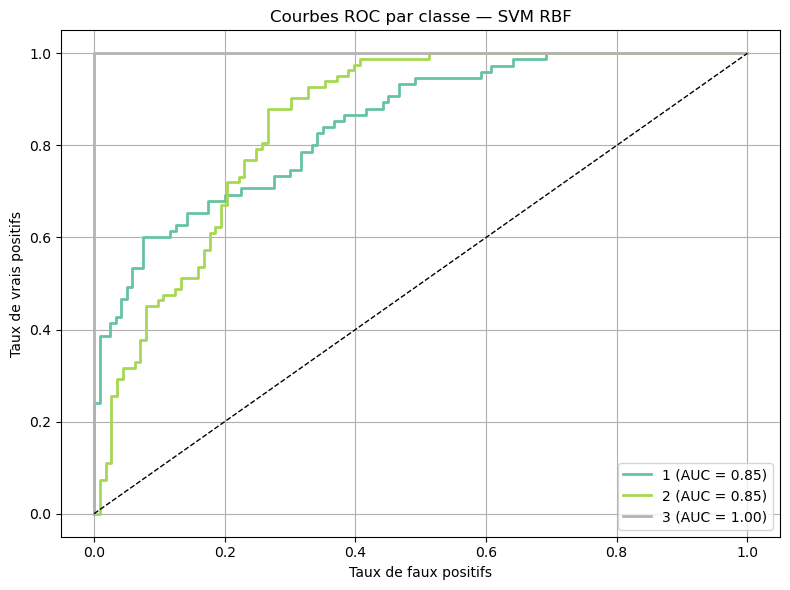

In [ ]:
# --- Grille de recherche conjointe pour C et gamma ---
param_grid_rbf = {
    'C': np.logspace(-2, 2, 10),
    'gamma': np.logspace(-4, 1, 10)
}

svm_rbf_grid = GridSearchCV(
    estimator=SVC(kernel='rbf', probability=True),
    param_grid=param_grid_rbf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec cross-validation ---
svm_rbf_grid.fit(X_train_encoded, y_train)

best_params_rbf = svm_rbf_grid.best_params_
best_C_rbf = best_params_rbf['C']
best_gamma_rbf = best_params_rbf['gamma']

print(f"[SVM RBF] Meilleur C : {best_C_rbf}")
print(f"[SVM RBF] Meilleur gamma : {best_gamma_rbf}")

# --- Entraînement final avec les meilleurs hyperparamètres ---
svm_rbf_model = SVC(
    kernel='rbf',
    C=best_C_rbf,
    gamma=best_gamma_rbf,
    probability=True,
    random_state=42
)
svm_rbf_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_svm_rbf = svm_rbf_model.predict(X_test_encoded)
y_proba_svm_rbf = svm_rbf_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_svm_rbf = plot_confusion_matrix(y_test, y_pred_svm_rbf, labels=svm_rbf_model.classes_)
erreur_pourcentage(conf_matrix_svm_rbf)

print("Rapport SVM RBF :")
print(classification_report(y_test, y_pred_svm_rbf))
report_svm_rbf = classification_report(y_test, y_pred_svm_rbf, output_dict=True)
f1_macro_svm_rbf = report_svm_rbf['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_svm_rbf:.4f}")
f1_dico_comp["SVM RBF"]=f1_macro_svm_rbf
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_svm_rbf,
    class_names=svm_rbf_model.classes_,
    model_name="SVM RBF"
)





# 2.2.4 Arbres et forêts aléatoires

**Abres binaires de décision** (CART)


[CART] Meilleure profondeur (max_depth) : 4


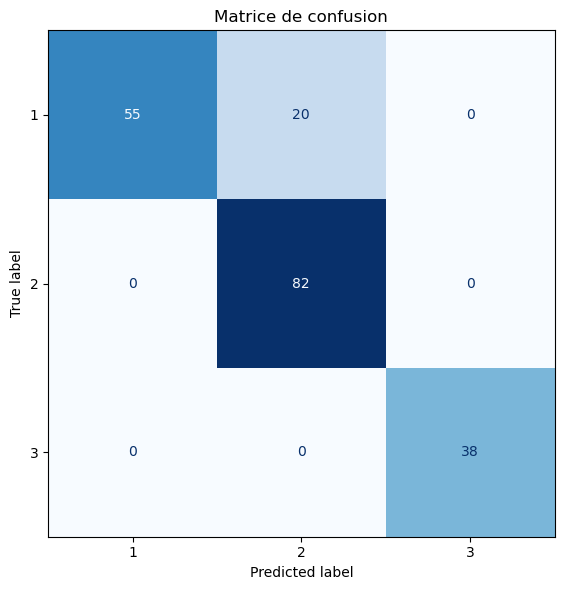

Pourcentage d'erreur : 10.26 %
Rapport CART :
              precision    recall  f1-score   support

           1       1.00      0.73      0.85        75
           2       0.80      1.00      0.89        82
           3       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.93      0.91      0.91       195
weighted avg       0.92      0.90      0.90       195

F1-score macro : 0.9125


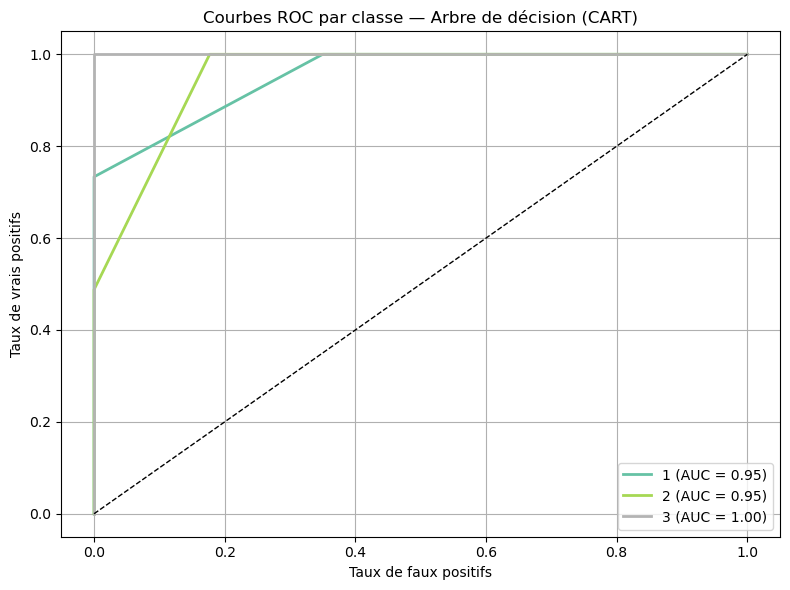

In [ ]:

# --- Grille de paramètres : profondeur maximale de l'arbre ---
param_grid_cart = {'max_depth': list(range(2, 15))}

cart_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_cart,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec validation croisée ---
cart_grid.fit(X_train_encoded, y_train)

best_depth_cart = cart_grid.best_params_['max_depth']
print(f"[CART] Meilleure profondeur (max_depth) : {best_depth_cart}")

# --- Entraînement final avec la profondeur optimale ---
cart_model = DecisionTreeClassifier(max_depth=best_depth_cart, random_state=42)
cart_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_cart = cart_model.predict(X_test_encoded)
y_proba_cart = cart_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_cart = plot_confusion_matrix(y_test, y_pred_cart, labels=cart_model.classes_)
erreur_pourcentage(conf_matrix_cart)

print("Rapport CART :")
print(classification_report(y_test, y_pred_cart))
report_cart = classification_report(y_test, y_pred_cart, output_dict=True)
f1_macro_cart = report_cart['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_cart:.4f}")
f1_dico_comp["CART"]=f1_macro_cart
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_cart,
    class_names=cart_model.classes_,
    model_name="Arbre de décision (CART)"
)






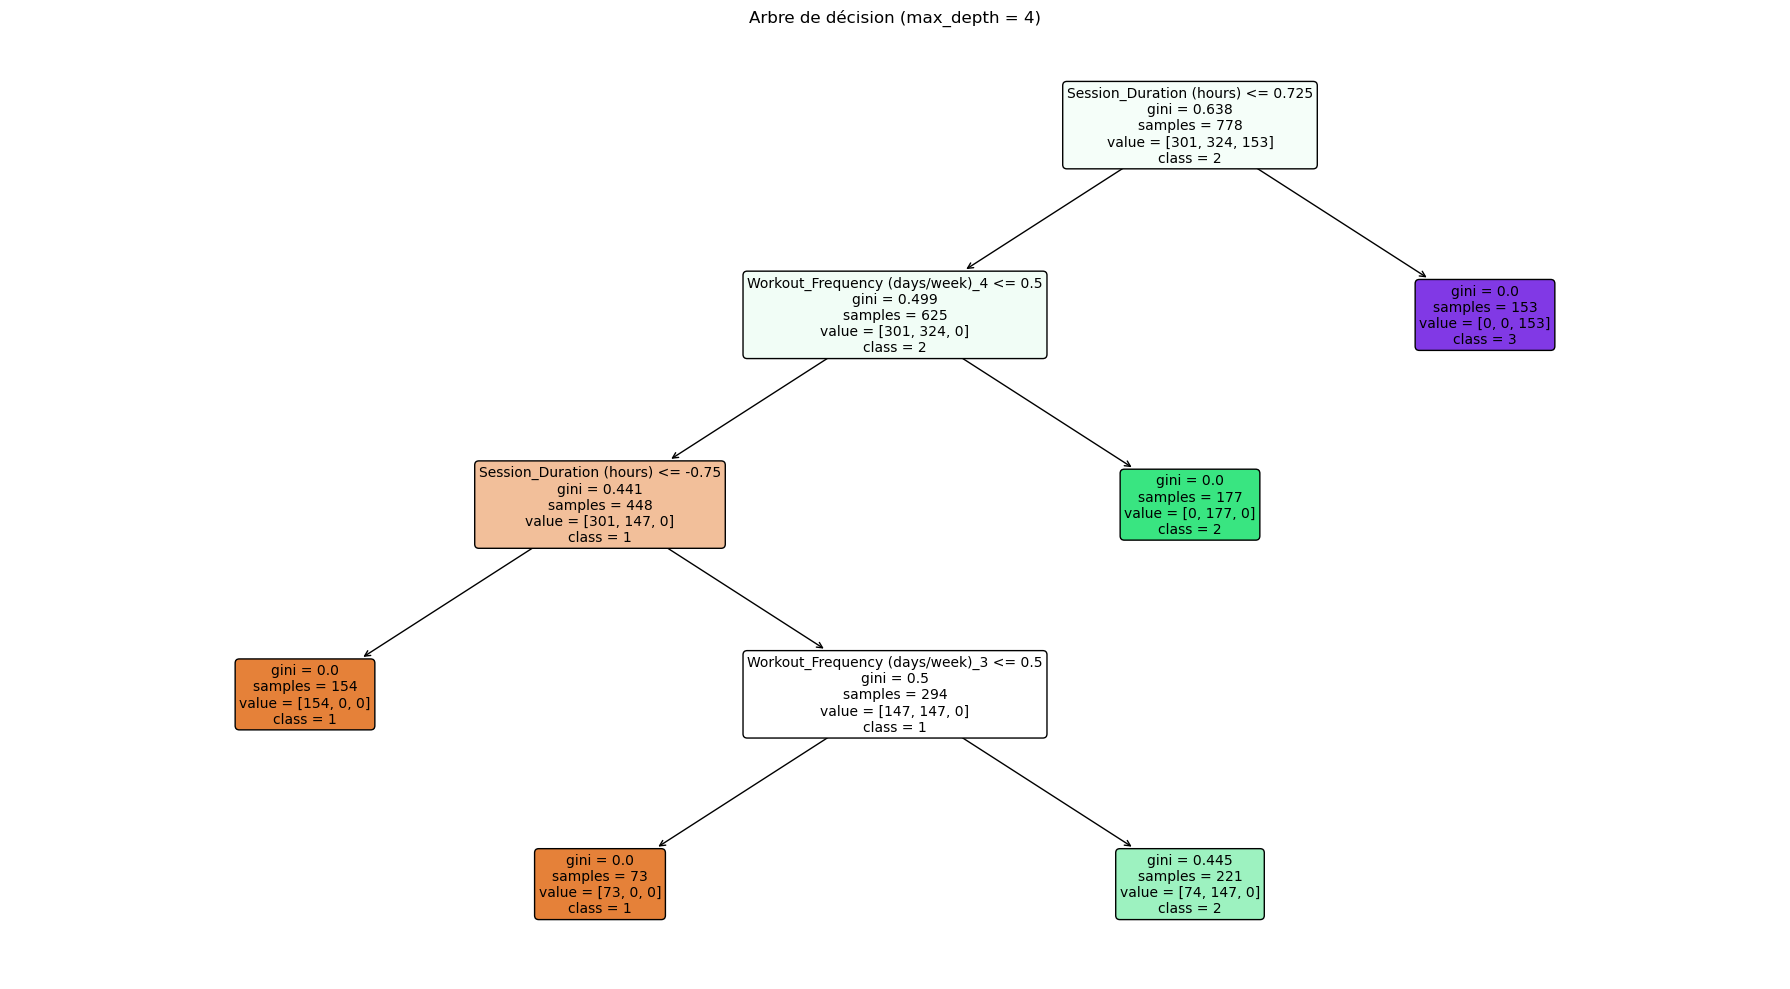

In [ ]:

plt.figure(figsize=(18, 10))
plot_tree(
    cart_model,
    feature_names=X_train_encoded.columns,
    class_names=[str(cls) for cls in cart_model.classes_],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Arbre de décision (max_depth = {best_depth_cart})")
plt.tight_layout()
plt.show()


# Random Forest

[Random Forest] Meilleur n_estimators : 100
[Random Forest] Meilleur max_depth : 10


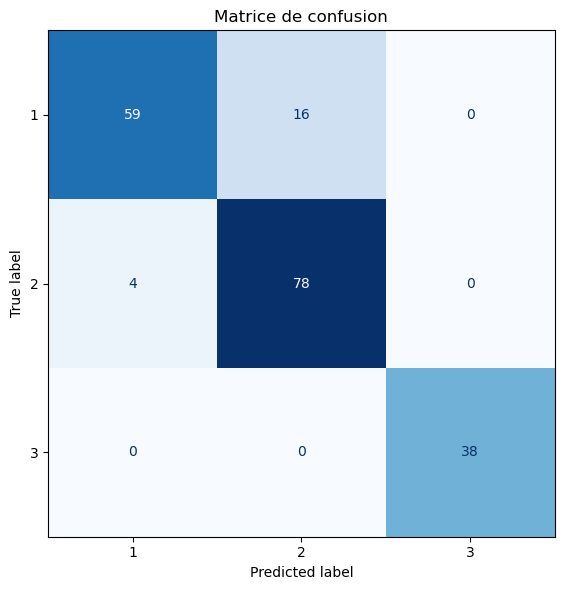

Pourcentage d'erreur : 10.26 %
Rapport Random Forest :
              precision    recall  f1-score   support

           1       0.94      0.79      0.86        75
           2       0.83      0.95      0.89        82
           3       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.92      0.91      0.91       195
weighted avg       0.90      0.90      0.90       195

F1-score macro : 0.9138


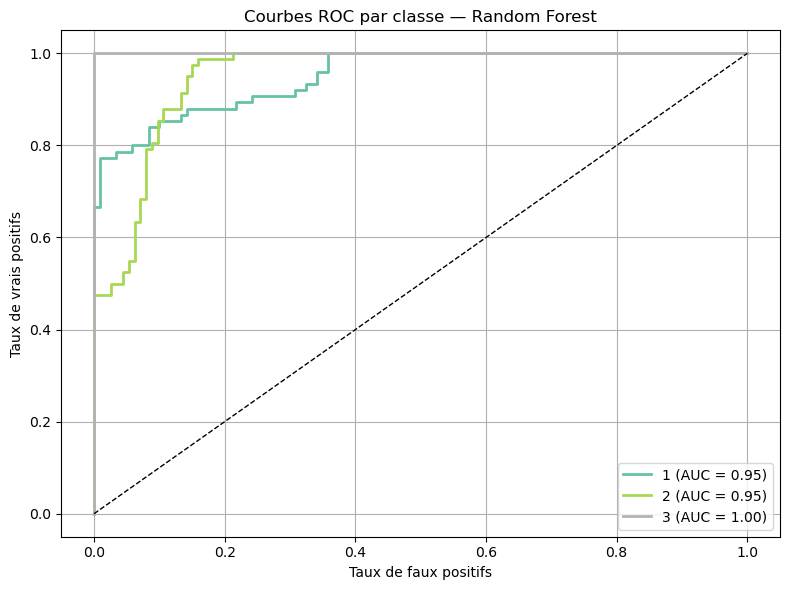

In [ ]:


# --- Grille de recherche pour Random Forest ---
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, None]
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec validation croisée ---
rf_grid.fit(X_train_encoded, y_train)

best_params_rf = rf_grid.best_params_
best_n_estimators = best_params_rf['n_estimators']
best_max_depth = best_params_rf['max_depth']

print(f"[Random Forest] Meilleur n_estimators : {best_n_estimators}")
print(f"[Random Forest] Meilleur max_depth : {best_max_depth}")

# --- Entraînement final ---
rf_model = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    random_state=42
)
rf_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_rf = rf_model.predict(X_test_encoded)
y_proba_rf = rf_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_rf = plot_confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)
erreur_pourcentage(conf_matrix_rf)

print("Rapport Random Forest :")
print(classification_report(y_test, y_pred_rf))
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
f1_macro_rf = report_rf['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_rf:.4f}")
f1_dico_comp["Random Forest"]=f1_macro_rf
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_rf,
    class_names=rf_model.classes_,
    model_name="Random Forest"
)





# Gradient Boosting

[Gradient Boosting] Best params : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


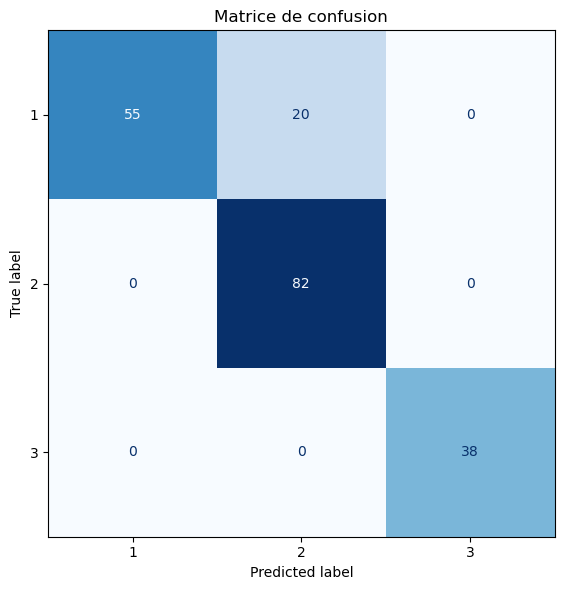

Pourcentage d'erreur : 10.26 %
Rapport Gradient Boosting :
              precision    recall  f1-score   support

           1       1.00      0.73      0.85        75
           2       0.80      1.00      0.89        82
           3       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.93      0.91      0.91       195
weighted avg       0.92      0.90      0.90       195

F1-score macro : 0.9125


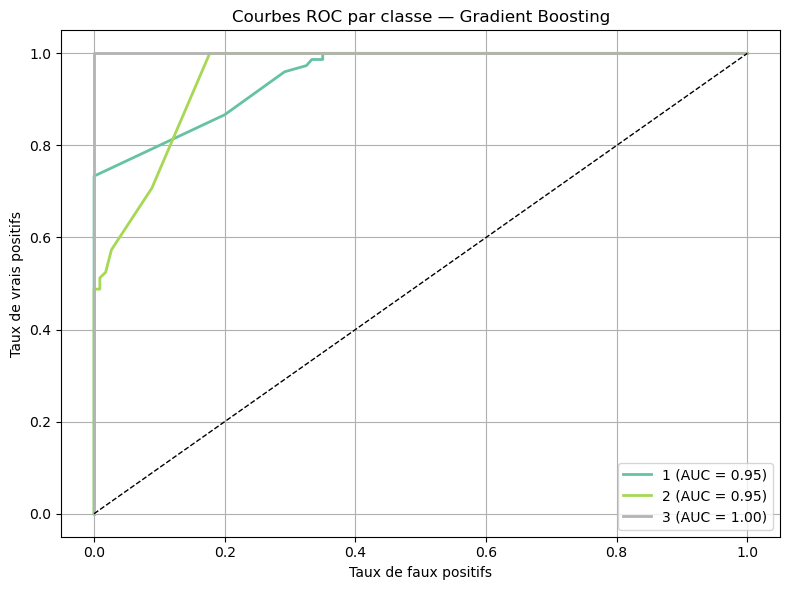

In [ ]:

# --- Grille de paramètres ---
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# --- Entraînement avec validation croisée ---
gb_grid.fit(X_train_encoded, y_train)

best_params_gb = gb_grid.best_params_
print(f"[Gradient Boosting] Best params : {best_params_gb}")

# --- Entraînement final ---
gb_model = GradientBoostingClassifier(
    n_estimators=best_params_gb['n_estimators'],
    learning_rate=best_params_gb['learning_rate'],
    max_depth=best_params_gb['max_depth'],
    random_state=42
)
gb_model.fit(X_train_encoded, y_train)

# --- Prédictions ---
y_pred_gb = gb_model.predict(X_test_encoded)
y_proba_gb = gb_model.predict_proba(X_test_encoded)

# --- Évaluation ---
conf_matrix_gb = plot_confusion_matrix(y_test, y_pred_gb, labels=gb_model.classes_)
erreur_pourcentage(conf_matrix_gb)

print("Rapport Gradient Boosting :")
print(classification_report(y_test, y_pred_gb))
report_GradBoost = classification_report(y_test, y_pred_gb, output_dict=True)
f1_macro_GradBoost = report_GradBoost['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_GradBoost:.4f}")
f1_dico_comp["Grad Boosting"]=f1_macro_GradBoost
# --- Courbes ROC ---
plot_roc_curves(
    y_true=y_test,
    y_probs=y_proba_gb,
    class_names=gb_model.classes_,
    model_name="Gradient Boosting"
)





# XGBoost

c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[XGBoost] Best parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


c:\Users\edgar\anaconda3\envs\tf-scikit\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


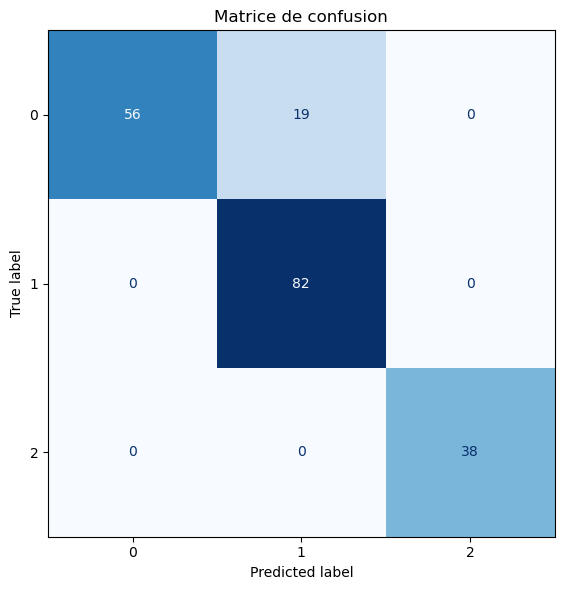

Pourcentage d'erreur : 9.74 %
Rapport XGBoost :
              precision    recall  f1-score   support

           0       1.00      0.75      0.85        75
           1       0.81      1.00      0.90        82
           2       1.00      1.00      1.00        38

    accuracy                           0.90       195
   macro avg       0.94      0.92      0.92       195
weighted avg       0.92      0.90      0.90       195

F1-score macro : 0.9170


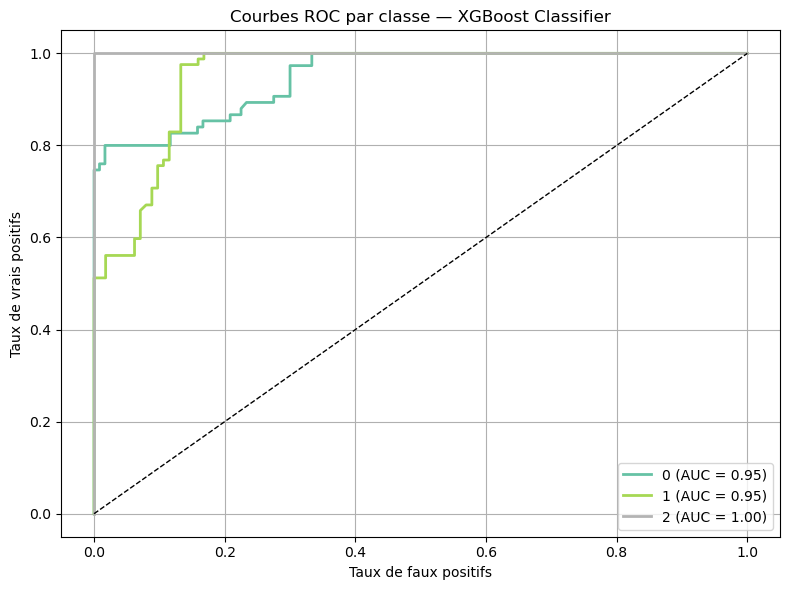

In [ ]:


# Encodage des classes pour XGBoost (attend des entiers 0, 1, 2)
y_train_xgb = y_train.astype('category').cat.codes
y_test_xgb = y_test.astype('category').cat.codes
class_names_xgb = np.unique(y_train_xgb)

#  Grille d’hyperparamètres
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names_xgb),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

#  Grid search avec validation croisée
xgb_grid.fit(X_train_encoded, y_train_xgb)
best_params_xgb = xgb_grid.best_params_
print(f"[XGBoost] Best parameters : {best_params_xgb}")

#  Entraînement final avec les meilleurs hyperparamètres
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names_xgb),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    **best_params_xgb
)
xgb_model.fit(X_train_encoded, y_train_xgb)

#  Prédictions et probabilités
y_pred_xgb = xgb_model.predict(X_test_encoded)
y_proba_xgb = xgb_model.predict_proba(X_test_encoded)

#  Évaluation
conf_matrix_xgb = plot_confusion_matrix(y_test_xgb, y_pred_xgb, labels=class_names_xgb)
erreur_pourcentage(conf_matrix_xgb)

print("Rapport XGBoost :")
print(classification_report(y_test_xgb, y_pred_xgb))
report_XGBoost = classification_report(y_test_xgb, y_pred_xgb, output_dict=True)
f1_macro_XGBoost = report_XGBoost['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_XGBoost:.4f}")
f1_dico_comp["XGBoost"]=f1_macro_XGBoost
plot_roc_curves(
    y_true=y_test_xgb,
    y_probs=y_proba_xgb,
    class_names=class_names_xgb,
    model_name="XGBoost Classifier"
)




# Réseaux de neurones

Epoch 1/300
20/20 [==============================] - 1s 13ms/step - loss: 0.9577 - accuracy: 0.4920 - val_loss: 0.7626 - val_accuracy: 0.7308
Epoch 2/300
20/20 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.6897 - val_loss: 0.5486 - val_accuracy: 0.7949
Epoch 3/300
20/20 [==============================] - 0s 3ms/step - loss: 0.4853 - accuracy: 0.8103 - val_loss: 0.4173 - val_accuracy: 0.8205
Epoch 4/300
20/20 [==============================] - 0s 3ms/step - loss: 0.3976 - accuracy: 0.8328 - val_loss: 0.3578 - val_accuracy: 0.8269
Epoch 5/300
20/20 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8344 - val_loss: 0.3378 - val_accuracy: 0.8333
Epoch 6/300
20/20 [==============================] - 0s 2ms/step - loss: 0.3111 - accuracy: 0.8537 - val_loss: 0.3257 - val_accuracy: 0.8205
Epoch 7/300
20/20 [==============================] - 0s 3ms/step - loss: 0.2964 - accuracy: 0.8521 - val_loss: 0.3238 - val_accuracy: 0.8205
Epoch 8/300


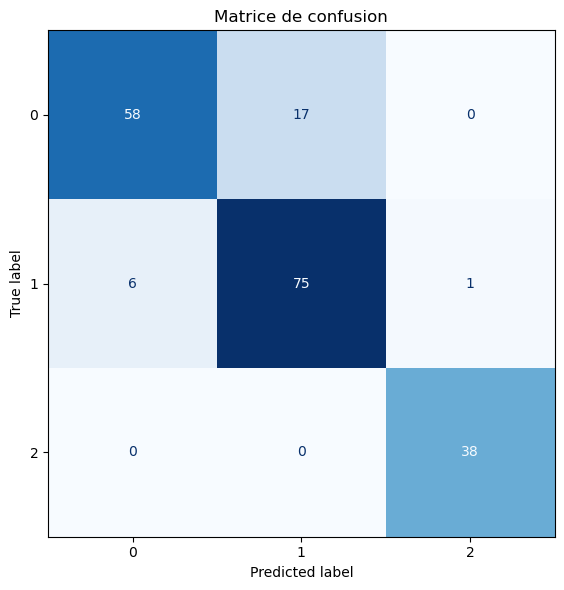

Pourcentage d'erreur : 12.31 %
Rapport MLP (TensorFlow) :
F1-score macro : 0.8945


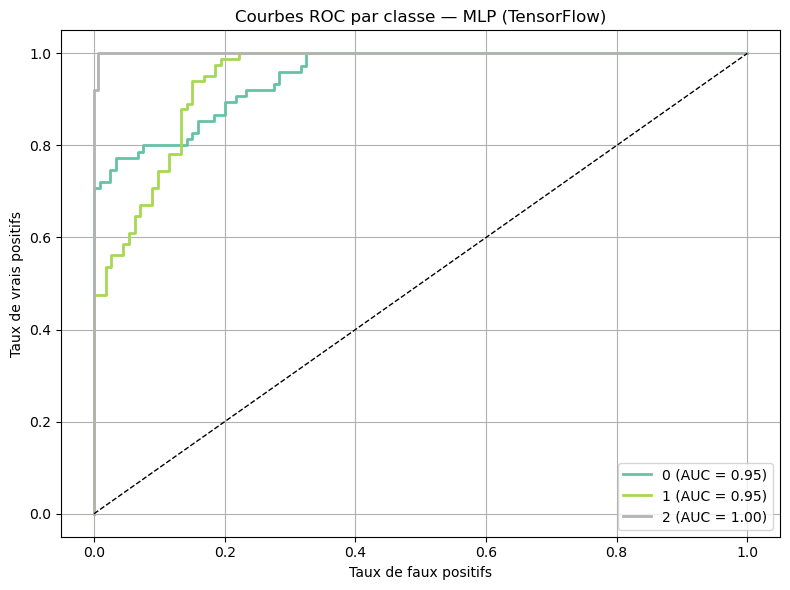

In [ ]:
#  Variables retenues (corrélées à la cible)
mlp_features = [
    'Gender', 'Workout_Type', 'Workout_Frequency (days/week)',
    'Session_Duration (hours)', 'Avg_BPM', 'sCalories_Burned'
]

#  Extraction des features + encodage
X_train_raw = data_exp_norm[mlp_features]
X_test_raw = data_test_norm[mlp_features]

y_train_tf = data_exp_norm['Experience_Level'].astype(int) - 1  
y_test_tf = data_test_norm['Experience_Level'].astype(int) - 1

X_train_encoded = pd.get_dummies(X_train_raw, drop_first=False)
X_test_encoded = pd.get_dummies(X_test_raw, drop_first=False)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Standardisation
scaler_mlp = StandardScaler()
X_train_scaled = scaler_mlp.fit_transform(X_train_encoded)
X_test_scaled = scaler_mlp.transform(X_test_encoded)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#  Architecture du MLP
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')  
])

mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Entraînement
history = mlp_model.fit(
    X_train_scaled,
    y_train_tf,
    epochs=300,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Prédictions
y_proba_mlp = mlp_model.predict(X_test_scaled)
y_pred_mlp = np.argmax(y_proba_mlp, axis=1)

#  Matrice de confusion
conf_matrix_mlp = plot_confusion_matrix(y_test_tf, y_pred_mlp, labels=[0, 1, 2])
erreur_pourcentage(conf_matrix_mlp)

#  Rapport de classification
print("Rapport MLP (TensorFlow) :")
report_MLP = classification_report(y_test_tf, y_pred_mlp, output_dict=True)
f1_macro_MLP = report_MLP['macro avg']['f1-score']
print(f"F1-score macro : {f1_macro_MLP:.4f}")
f1_dico_comp["MLP"]=f1_macro_MLP
#  Courbes ROC
plot_roc_curves(
    y_true=y_test_tf,
    y_probs=y_proba_mlp,
    class_names=[0, 1, 2],
    model_name="MLP (TensorFlow)"
)



# Comparaison des méthodes 

{'Multi reg': 0.887955643390426, 'Ridge': 0.8168697886765631, 'Lasso': 0.8168697886765631, 'LDA': 0.9090420028967515, 'kNN': 0.6505901505901506, 'SVM RBF': 0.7798463489222048, 'CART': 0.9124860646599777, 'Random Forest': 0.9138120333772507, 'Grad Boosting': 0.9124860646599777, 'XGBoost': 0.9170455651496824, 'MLP': 0.8945381088769825}


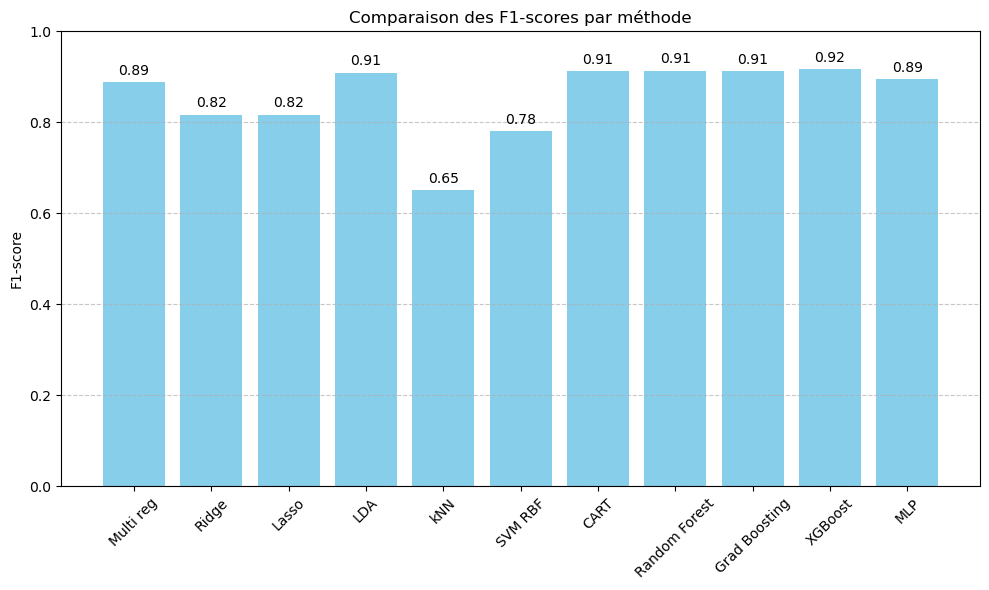

In [ ]:
print(f1_dico_comp)
# Exemple de dictionnaire avec F1-scores
f1_scores=f1_dico_comp
# Préparer les données
methods = list(f1_scores.keys())
scores = list(f1_scores.values())

# Tracé
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, scores, color='skyblue')
plt.ylim(0, 1)
plt.ylabel('F1-score')
plt.title('Comparaison des F1-scores par méthode')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher les valeurs sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

| Méthode                      | F1-score  | Remarque                                                                                                                                                |
| ---------------------------- | --------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **XGBoost**                  | **0.92**  | Meilleure performance. Excellent compromis biais-variance, robuste au surapprentissage, efficace avec peu de réglages.                                  |
| **Random Forest**            | 0.91      | Très bon score. Robuste, peu sensible aux données bruitées.                                                                                             |
| **Gradient Boosting**        | 0.91      | Comparable à XGBoost, mais souvent un peu plus lent à entraîner.                                                                                        |
| **CART (Arbre)**             | 0.91      | Bon score malgré sa simplicité. Peut surapprendre si non régularisé.                                                                                    |
| **Ridge, Lasso, Multi Reg**  | 0.90      | Méthodes linéaires performantes ici. Signale que les classes sont probablement bien séparables linéairement.                                            |
| **SVM Linéaire**             | 0.89      | Proche des modèles linéaires classiques, ce qui confirme cette linéarité.                                                                               |
| **SVM RBF /**           | 0.87 | Pas un gain net ici par rapport à la version linéaire : probablement pas de structure non linéaire complexe dans les données.                           |
| **MLP (réseau de neurones)** | 0.89      | Correct, mais pas supérieur aux méthodes ensemblistes. Peut nécessiter plus de données ou de réglages.                                                  |
| **LDA**                      | 0.89      | Bon score, en cohérence avec des données possiblement gaussiennes ou bien séparables.                                                                   |
| **kNN**                      | **0.83**  | Moins bon. Sensible à la dimension, au bruit et à la métrique. Indique que les frontières de classes ne sont pas facilement localisables par proximité. |
